In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from scipy.optimize import differential_evolution
import statsmodels.api as sm
import pickle

In [3]:
file_path = '../../Data/Real world/'

# Load datasets for 2020, 2021, and 2022
# google mobility data
data_2020 = pd.read_csv(file_path+"2020_US_Region_Mobility_Report.csv")  # 2020 data
data_2021 = pd.read_csv(file_path+"2021_US_Region_Mobility_Report.csv")  # 2021 data
data_2022 = pd.read_csv(file_path+"2022_US_Region_Mobility_Report.csv")  # 2022 data

# CDC covid data
deaths = pd.read_csv(file_path+"Weekly_United_States_COVID-19_Cases_and_Deaths_by_State_-_ARCHIVED_20240311.csv")

# Census 2020 Population Data
population = pd.read_csv(file_path+"PopulationEstimates.csv", skiprows = 4)
# print(population.head)

In [4]:
# Filter each dataset to retain only the aggregate state information (empty county)
data_2020_aggregate = data_2020[data_2020['sub_region_2'].isna() & data_2020['sub_region_1'].notna()]
data_2021_aggregate = data_2021[data_2021['sub_region_2'].isna() & data_2021['sub_region_1'].notna()]
data_2022_aggregate = data_2022[data_2022['sub_region_2'].isna() & data_2022['sub_region_1'].notna()]



deaths_necessary = deaths[['state', 'end_date', 'new_cases', 'new_deaths']]


#print(deaths_necessary)

us_states = [
    'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
    'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky',
    'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri',
    'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina',
    'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota',
    'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'
]

pop_necessary = population[population['Area_Name'].isin(us_states)][['State', 'POP_ESTIMATE_2020', 'POP_ESTIMATE_2021', 'POP_ESTIMATE_2022']]
pop_necessary.rename(columns={'State': 'state'}, inplace=True)

deaths_necessary_merged_pop = deaths_necessary.merge(pop_necessary, on = 'state')
deaths_necessary_merged_pop['date'] = pd.to_datetime(deaths_necessary_merged_pop['end_date'])
deaths_necessary_merged_pop.set_index('date', inplace=True)
deaths_necessary_merged_pop = deaths_necessary_merged_pop[deaths_necessary_merged_pop.index >= '2020-02-20']
deaths_necessary_merged_pop = deaths_necessary_merged_pop[deaths_necessary_merged_pop.index <= '2022-12-31']
deaths_necessary_merged_pop[['POP_ESTIMATE_2020', 'POP_ESTIMATE_2021', 'POP_ESTIMATE_2022']] = deaths_necessary_merged_pop[['POP_ESTIMATE_2020', 'POP_ESTIMATE_2021', 'POP_ESTIMATE_2022']].replace(',', '', regex=True)
deaths_necessary_merged_pop[['POP_ESTIMATE_2020', 'POP_ESTIMATE_2021', 'POP_ESTIMATE_2022']] = deaths_necessary_merged_pop[['POP_ESTIMATE_2020', 'POP_ESTIMATE_2021', 'POP_ESTIMATE_2022']].astype(int)

# Define a function to calculate the population rate
def calculate_population_rate(row, raw_col):
    year = row.name.year
    population_column = f'POP_ESTIMATE_{year}'
    return row[raw_col] / row[population_column]

def calculate_population_rate2(row, raw_col):
    year = row.name.year
    population_column = f'POP_ESTIMATE_{year}'
    return row[raw_col] / row[population_column]*1000000

# Apply the function to calculate the case rate
#deaths_necessary_merged_pop['case_rate'] = deaths_necessary_merged_pop.apply(
#    lambda row: calculate_population_rate(row, 'new_cases'), axis=1
#)

# Apply the function to calculate the case rate
deaths_necessary_merged_pop['case_rate'] = deaths_necessary_merged_pop.apply(
    lambda row: calculate_population_rate2(row, 'new_cases'), axis=1
)


# Apply the function to calculate the case rate
deaths_necessary_merged_pop['death_rate'] = deaths_necessary_merged_pop.apply(
    lambda row: calculate_population_rate2(row, 'new_deaths'), axis=1
)

# Dictionary mapping state abbreviations to full state names
state_abbreviation_to_name = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'DC': 'District of Columbia',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois',
    'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana',
    'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota',
    'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
    'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
    'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

# Assuming 'state' column contains state abbreviations, map abbreviations to full names
deaths_necessary_merged_pop['state_full_name'] = deaths_necessary_merged_pop['state'].map(state_abbreviation_to_name)


covid_rates = deaths_necessary_merged_pop[['state','state_full_name', 'case_rate', 'death_rate']]

print(covid_rates)


           state state_full_name    case_rate  death_rate
date                                                     
2020-02-26    AK          Alaska     0.000000    0.000000
2020-03-04    AK          Alaska     0.000000    0.000000
2020-03-11    AK          Alaska     0.000000    0.000000
2020-03-18    AK          Alaska    15.008398    0.000000
2020-03-25    AK          Alaska    70.948790    1.364400
...          ...             ...          ...         ...
2022-11-30    WY         Wyoming  1081.906701   12.040297
2022-12-07    WY         Wyoming  1164.468739    0.000000
2022-12-14    WY         Wyoming   703.497362   20.640509
2022-12-21    WY         Wyoming   686.296938   13.760340
2022-12-28    WY         Wyoming   435.170740    0.000000

[7748 rows x 4 columns]


In [5]:
# First, reset the index to make 'date' a column if it's currently set as the index
covid_rates.reset_index(inplace=True)

# Get the unique list of states and their full names
states_df = covid_rates[['state', 'state_full_name']].drop_duplicates()

# Create a DataFrame with the date 2020-02-19 for each state
date_to_add = pd.to_datetime('2020-02-19')
new_rows = states_df.copy()
new_rows['case_rate'] = 0
new_rows['death_rate'] = 0
new_rows['date'] = date_to_add

# Concatenate the new rows with the original DataFrame
covid_rates_with_zero = pd.concat([new_rows, covid_rates], ignore_index=True)

# Set 'date' back as the index
covid_rates_with_zero.set_index('date', inplace=True)

# Sort the DataFrame by 'state' and 'date'
covid_rates_with_zero.sort_values(['state', 'date'], inplace=True)

# Now, covid_rates_with_zero contains the extra rows with zeros for each state
print(covid_rates_with_zero.head())


           state state_full_name  case_rate  death_rate
date                                                   
2020-02-19    AK          Alaska   0.000000         0.0
2020-02-26    AK          Alaska   0.000000         0.0
2020-03-04    AK          Alaska   0.000000         0.0
2020-03-11    AK          Alaska   0.000000         0.0
2020-03-18    AK          Alaska  15.008398         0.0


In [6]:
merged_data = pd.concat([data_2020_aggregate, data_2021_aggregate, data_2022_aggregate])
merged_data['state'] = merged_data['iso_3166_2_code'].str.split('-', expand=True)[1]

# Reset index
merged_data.reset_index(drop=True, inplace=True)

# Convert 'date' column to datetime type
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Set 'date' column as the index
merged_data.set_index('date', inplace=True)

# remove all data before 2-20-2020
merged_data = merged_data[merged_data.index >= '2020-02-19']
merged_data = merged_data[merged_data.index <= '2022-12-31']

##### average mobility_index across mobility columns
columns_to_average = ['retail_and_recreation_percent_change_from_baseline', 'transit_stations_percent_change_from_baseline', 'workplaces_percent_change_from_baseline']  # Add your column names here

# Create a new column containing the average of the specified columns
merged_data['raw_mobility'] = merged_data[columns_to_average].mean(axis=1)
merged_data['mobility'] = 1 + merged_data['raw_mobility']/100

merged_data_necessary = merged_data[['state', 'mobility']]

##### split dataframe using callable dictionary structure

# Group the dataframe by 'sub_region_1' and create a dictionary
merged_data_grouped = merged_data_necessary.groupby('state')

# Initialize an empty dictionary to hold your dataframes
state_dict = {}

for index, (state, data) in enumerate(merged_data_grouped):
    # state_dict[state] = data
    # Also add the state data with index as key
    state_dict[index] = data

# Now you can access the data using either the state code or the index
# For example:
# state_data = state_dict['AL']  # Access data using state code
# state_data_index = state_dict[0]  # Access data using index

# Now, you can access each state's dataframe like this:
# state_dataframe = state_dict['YourStateName']
 
#print(state_dict["Alabama"][0:7]['mobility'].mean())
    
print(state_dict[1])



           state  mobility
date                      
2020-02-19    AL  1.030000
2020-02-20    AL  0.973333
2020-02-21    AL  1.043333
2020-02-22    AL  1.080000
2020-02-23    AL  1.070000
...          ...       ...
2022-10-11    AL  0.966667
2022-10-12    AL  0.953333
2022-10-13    AL  0.986667
2022-10-14    AL  0.976667
2022-10-15    AL  1.010000

[970 rows x 2 columns]


In [7]:
for index, data in state_dict.items():
    state = data.state
    # mean
    resampled_data = data.resample('W-Wed').mean(numeric_only=True)
    put_state_back = resampled_data.merge(state, on='date')
    
    # Merge 
    merged_data = put_state_back.merge(covid_rates_with_zero, on=['date', 'state'])
    print(merged_data.head)
    #merged_data = merged_data[['mobility', 'case_rate',  'death_rate', 'state']]
    merged_data = merged_data[['mobility', 'case_rate', 'death_rate', 'state', 'state_full_name']]

    #re-save to dict
    state_dict[index] = merged_data




<bound method NDFrame.head of             mobility state state_full_name    case_rate  death_rate
date                                                               
2020-02-19  1.003333    AK          Alaska     0.000000    0.000000
2020-02-26  1.037143    AK          Alaska     0.000000    0.000000
2020-03-04  1.080000    AK          Alaska     0.000000    0.000000
2020-03-11  1.045714    AK          Alaska     0.000000    0.000000
2020-03-18  0.952381    AK          Alaska    15.008398    0.000000
...              ...   ...             ...          ...         ...
2022-09-14  1.215238    AK          Alaska  1295.013652   34.079307
2022-09-21  1.195238    AK          Alaska   877.882939    0.000000
2022-09-28  1.146190    AK          Alaska   749.744746    0.000000
2022-10-05  1.093810    AK          Alaska   868.340733   36.805651
2022-10-12  1.038571    AK          Alaska   696.581028    0.000000

[139 rows x 5 columns]>
<bound method NDFrame.head of             mobility state stat

In [8]:
#remove duplicate rows
state_dict[7] = state_dict[7].drop_duplicates()

state_dict[7]


mobility   case_rate  death_rate state       state_full_name
date                                                                    
2020-02-19  0.966667    0.000000    0.000000    DC  District of Columbia
2020-02-26  1.013810    0.000000    0.000000    DC  District of Columbia
2020-03-04  1.027143    0.000000    0.000000    DC  District of Columbia
2020-03-11  1.020476    2.981212    0.000000    DC  District of Columbia
2020-03-18  0.689048   55.152429    0.000000    DC  District of Columbia
...              ...         ...         ...   ...                   ...
2022-09-14  0.633333  771.059373    0.000000    DC  District of Columbia
2022-09-21  0.650952  915.446939    1.488532    DC  District of Columbia
2022-09-28  0.649524  747.242867    0.000000    DC  District of Columbia
2022-10-05  0.619524  421.254445   13.396784    DC  District of Columbia
2022-10-12  0.639048  175.646730    0.000000    DC  District of Columbia

[139 rows x 5 columns]

In [9]:
# Assuming state_dict is your dataset and it is a dictionary of DataFrames
for state, df in state_dict.items():
    # Make a copy of the DataFrame to avoid modifying a view
    df = df.copy()
    
    # Calculate delta_mobility as the difference between max_mobility and mobility
    #df['delta_mobility'] = 1 - df['mobility'].shift(1)
    
    # Calculate cumulative_delta_mobility as the cumulative sum of delta_mobility
    df['cumulative_case_rate'] = df['case_rate'].cumsum()

    #add 1 to all cumalative case rates
    #df['cumulative_case_rate'] = df['cumulative_case_rate'] + 1

    #df = df[df['death_rate'] >= 0]

    #df = df[df['case_rate'] >= 0]

    #remove rows with NA
    #df = df.dropna()

    
    # Assign the updated DataFrame back to the dictionary
    state_dict[state] = df

# Now, each DataFrame in state_dict will have the additional columns 'max_mobility', 'delta_mobility', and 'cumulative_delta_mobility'


In [11]:
#save state_dict

import pickle

with open('state_dict.pickle', 'wb') as handle:
    pickle.dump(state_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)





In [12]:
#load state_dict
with open('state_dict.pickle', 'rb') as handle:
    state_dict = pickle.load(handle)

In [13]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

def Mob_delay_asy_n2(values, d1, d2, o, alpha):
    df = values.copy()
    df = df.reset_index(drop=True)

    o = round(o)  # Ensure 'o' is an integer

    # Creating shifted columns based on the order 'o'
    for i in range(0, o + 1):
        column_name = f"B_est_{i}"
        df[column_name] = df["case_rate"].astype(float)

    # Applying the delay logic
    for i in range(0, len(df["case_rate"]) - 1):
        if df.loc[i, 'case_rate'] < df.loc[i, f'B_est_{o}']:
            d = d2
        else:
            d = d1

        for j in range(1, o + 1):
            prev_column = f'B_est_{j-1}'
            current_column = f'B_est_{j}'
            df.loc[i + 1, current_column] = df.loc[i, current_column] + (df.loc[i, prev_column] - df.loc[i, current_column]) / (d / o)

    # Preparing the X (independent variable) and y (dependent variable) arrays

    #if cumulative_case_rate is zero then X is zero
    #X = df[f"B_est_{o}"]/df['cumulative_case_rate']**(alpha/100)

    denominator = df['cumulative_case_rate'].copy()
    denominator[denominator == 0] = 1
    X = df[f"B_est_{o}"] / (denominator ** (alpha / 100))

    y = np.log(df['mobility']).values

    #X = sm.add_constant(X)

    
    # Fitting the model using statsmodels
    model = sm.OLS(y, X).fit()

    # Getting the model's predictions
    y_pred = model.predict(X)

    # Calculating the Mean Squared Error manually, since statsmodels doesn't provide it directly
    mse = np.mean((y - y_pred) ** 2)

    # Extracting the model's coefficients
    # Note: In a model without an intercept, there's just one coefficient for the predictor
    coefficients = model.params
    # Mean Absolute Error
    #mae = mean_absolute_error(y, y_pred)
    # R-squared
    #r_squared = model.rsquared
    # AIC
    aic = model.aic
    # BIC
    #bic = model.bic
    # Confidence Intervals for the coefficients
    ci = model.conf_int()

    y= df['mobility'].values
    y_hat = np.exp(y_pred).values

    mae = np.mean(np.abs(y_hat - y))

    n = len(df['mobility']) #length of the data
    k = 1 #number of predictors
    bic = n * np.log((1/n) * np.sum((y - y_hat) ** 2)) + k * np.log(n)

    correlation_matrix = np.corrcoef(y_hat, y)
    correlation_coefficient = correlation_matrix[0, 1]

    r_squared = correlation_coefficient ** 2

    return mse, coefficients, mae, r_squared, aic, bic, ci


In [14]:
def create_objective_function(values):
    def objective(params):
        delay1, delay2, order, alpha = map(int, params)  # Ensure parameters are integers
        mse, _, _, _, _, _, _= Mob_delay_asy_n2(values, delay1, delay2, order, alpha)
        return mse
    return objective


In [14]:
# Assuming 'simulation_dict' contains your datasets
# initilize 'answers' DataFrame to store the results
answers_asy_test = pd.DataFrame(columns=['state', 'best_order','best_mse', 'best_k', 'best_mae', 'best_r_squared', 'best_bic', 'k_lower_limit','k_upper_limit'])

# Define bounds for delay and order
benchmark_bounds = [(1, 201), (1, 201), (1, 11), (1, 100)]

# Adjusted loop to use differential_evolution
for i in range(51):  # Assuming you want to process simulations indexed from 1 to 10
    
    #values = state_dict[i+1]  # Access the dataset for the current state data
    values = state_dict[i] # replace with actual data
    state = state_dict[i].iloc[0]['state']

    # Create a customized objective function for the current dataset
    custom_objective = create_objective_function(values)
    
    # Perform the optimization using differential_evolution
    result = differential_evolution(custom_objective, benchmark_bounds)
    
    # Extract the optimal parameter values
    optimal_delay1, optimal_delay2, optimal_order, optimal_alpha = result.x
        
    # Recalculate mse and k using the optimal parameters
    mse, k, mae, r2, aic, bic, ci = Mob_delay_asy_n2(values, optimal_delay1, optimal_delay2, optimal_order, optimal_alpha)

    k_value = k.item()

    # Update 'answers' DataFrame with the optimization results

    answers_asy_test.loc[i, 'state'] = state
    answers_asy_test.loc[i, 'best_order'] = optimal_order
    answers_asy_test.loc[i, 'best_delay1'] = optimal_delay1
    answers_asy_test.loc[i, 'best_delay2'] = optimal_delay2
    answers_asy_test.loc[i, 'best_alpha'] = optimal_alpha
    answers_asy_test.loc[i, 'best_mse'] = mse
    answers_asy_test.loc[i, 'best_k'] = k_value
    answers_asy_test.loc[i, 'best_mae'] = mae
    answers_asy_test.loc[i, 'best_r_squared'] = r2
    #answers_asy_test.loc[i, 'best_aic'] = aic
    answers_asy_test.loc[i, 'best_bic'] = bic
    answers_asy_test.loc[i, 'k_lower_limit'] = ci.iloc[0][0]  # Assuming 'ci' is indexed [lower_bound, upper_bound]
    answers_asy_test.loc[i, 'k_upper_limit'] = ci.iloc[0][1]

    print(f"Simulation {i} completed")

Simulation 0 completed
Simulation 1 completed
Simulation 2 completed
Simulation 3 completed
Simulation 4 completed
Simulation 5 completed
Simulation 6 completed
Simulation 7 completed
Simulation 8 completed
Simulation 9 completed
Simulation 10 completed
Simulation 11 completed
Simulation 12 completed
Simulation 13 completed
Simulation 14 completed
Simulation 15 completed
Simulation 16 completed
Simulation 17 completed
Simulation 18 completed
Simulation 19 completed
Simulation 20 completed
Simulation 21 completed
Simulation 22 completed
Simulation 23 completed
Simulation 24 completed
Simulation 25 completed
Simulation 26 completed
Simulation 27 completed
Simulation 28 completed
Simulation 29 completed
Simulation 30 completed
Simulation 31 completed
Simulation 32 completed
Simulation 33 completed
Simulation 34 completed
Simulation 35 completed
Simulation 36 completed
Simulation 37 completed
Simulation 38 completed
Simulation 39 completed
Simulation 40 completed
Simulation 41 completed
Si

In [19]:
answers_asy= answers_asy_test.copy()

NameError: name 'answers_asy_test' is not defined

In [17]:
#load answers_asy
with open('answers_asy.pickle', 'rb') as handle:
    answers_asy = pickle.load(handle)

In [20]:
#calculate average R2

average_r2 = answers_asy['best_r_squared'].mean()

#calculate avergae delay 1 and delay 2

average_delay1 = answers_asy['best_delay1'].mean()
average_delay2 = answers_asy['best_delay2'].mean()

print(average_r2)
print(average_delay1)
print(average_delay2)

0.5433819982078743
7.228017892218722
45.91680974875614


In [21]:
#calcualte median R2

median_r2 = answers_asy['best_r_squared'].median()

#calculate median delay 1 and delay 2

median_delay1 = answers_asy['best_delay1'].median()
median_delay2 = answers_asy['best_delay2'].median()

print(median_r2)
print(median_delay1)
print(median_delay2)

#median k

median_k = answers_asy['best_k'].median()

#median alpha

median_alpha = answers_asy['best_alpha'].median()

print(median_k)
print(median_alpha)

0.5513109910619443
2.4252872246640464
26.09448702053041
-1.1810458377503659
93.26700008815261


In [22]:
#calculate average R2

average_r2 = answers_asy['best_r_squared'].mean()

print(average_r2)


0.5433819982078743


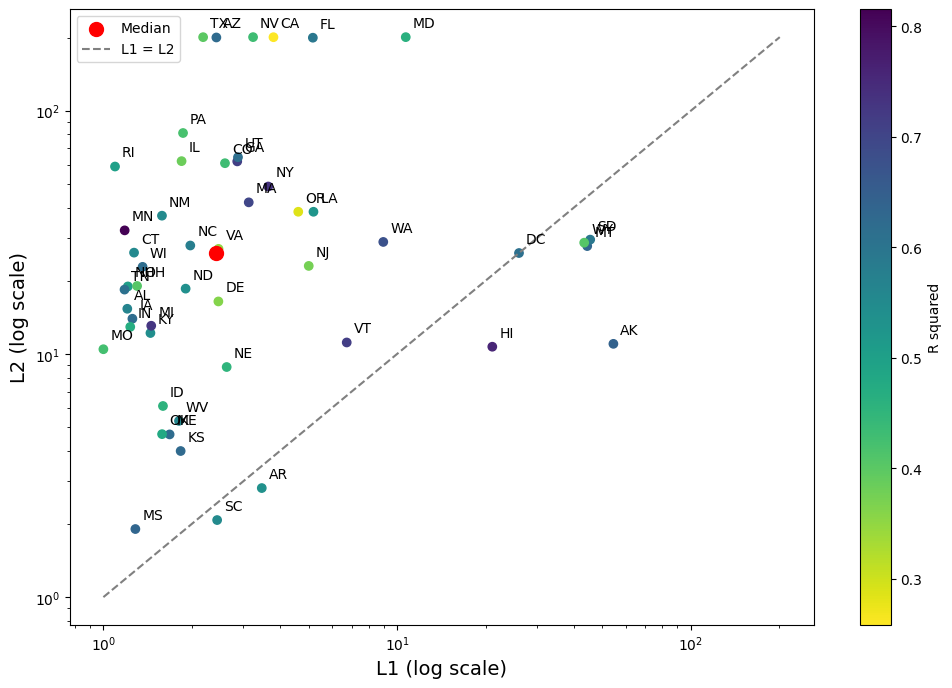

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'answers_asy' is your dataset in a pandas DataFrame or similar structure
# Extract the data
delay_1 = answers_asy["best_delay1"]
delay_2 = answers_asy["best_delay2"]
r_squared = answers_asy["best_r_squared"]
states = answers_asy["state"]

# Calculate medians
median_delay_1 = np.median(delay_1)
median_delay_2 = np.median(delay_2)

# Create a scatter plot
plt.figure(figsize=(12, 8))

# Use the reversed colormap 'viridis_r'
scatter = plt.scatter(delay_1, delay_2, c=r_squared, cmap='viridis_r')

# Logarithmic scale for both axes
plt.xscale('log')
plt.yscale('log')

# Adding state names to the points with an offset and larger fontsize
for i, state in enumerate(states):
    plt.annotate(
        state,
        (delay_1.iloc[i], delay_2.iloc[i]),
        xytext=(5, 5),  # Offset position (horizontal, vertical) in points
        textcoords='offset points',
        fontsize=10,    # Increase fontsize for larger text
        ha='left',      # Horizontal alignment
        va='bottom'     # Vertical alignment
    )

# Add the median point
plt.scatter(median_delay_1, median_delay_2, color='red', s=100, label='Median')

# Add a dashed line x = y
min_val = min(delay_1.min(), delay_2.min())
max_val = max(delay_1.max(), delay_2.max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='gray', label='L1 = L2')

# Adding colorbar to indicate R squared values
cbar = plt.colorbar(scatter)
cbar.set_label('R squared')

# Labels (No title)
plt.xlabel('L1 (log scale)', fontsize=14)
plt.ylabel('L2 (log scale)', fontsize=14)

# Optional: Add legend
plt.legend()

# Show plot
plt.show()


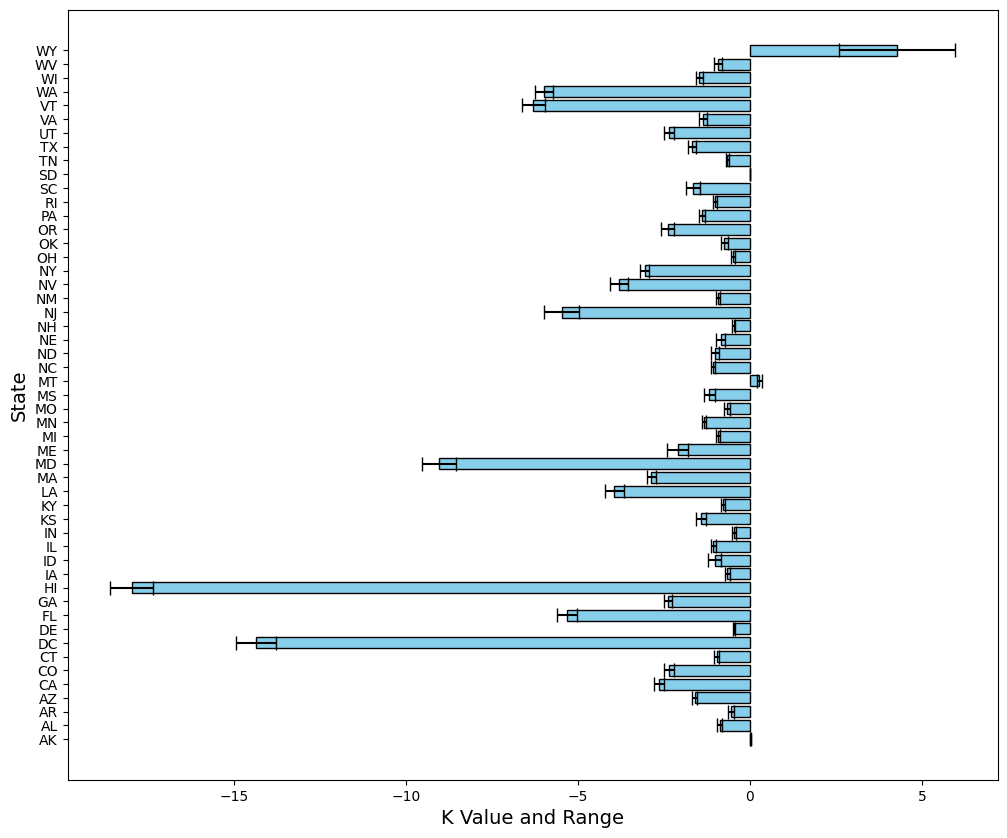

In [27]:
import matplotlib.pyplot as plt

# Extract the data from your dataset
states = answers_asy["state"]
best_k = answers_asy["best_k"]
k_lower_limit = answers_asy["k_lower_limit"]
k_upper_limit = answers_asy["k_upper_limit"]

# Calculate the error bars (range) for each K value
k_error = [best_k - k_lower_limit, k_upper_limit - best_k]

# Create a horizontal bar chart
plt.figure(figsize=(12, 10))
plt.barh(states, best_k, xerr=k_error, color='skyblue', edgecolor='black', capsize=5)

# Labels and title
plt.xlabel('K Value and Range', fontsize=14)  # Adjust fontsize as needed
plt.ylabel('State', fontsize=14) 
#plt.title('Bar Chart of Effect size K with 95 percentile intervals for Each State')

# Display the plot
plt.show()


In [30]:
predicted_mobility = {}
#predicted_mobility have the same index as state_dict



for s in range(51):
    
    values= state_dict[s]

    d1=answers_asy.loc[s, 'best_delay1']
    #d1= 1
    d2=answers_asy.loc[s, 'best_delay2']
    #d2= 5
    o= answers_asy.loc[s, 'best_order']
    #o= 1
    alpha = answers_asy.loc[s, 'best_alpha']


    df = values.copy()
    df = df.reset_index(drop=True)

    o = round(o)  # Ensure 'o' is an integer

    # Creating shifted columns based on the order 'o'
    for i in range(0, o + 1):
        column_name = f"B_est_{i}"
        df[column_name] = df["case_rate"].astype(float)

    # Applying the delay logic
    for i in range(0, len(df["case_rate"]) - 1):
        if df.loc[i, 'case_rate'] < df.loc[i, f'B_est_{o}']:
            d = d2
        else:
            d = d1

        for j in range(1, o + 1):
            prev_column = f'B_est_{j-1}'
            current_column = f'B_est_{j}'
            df.loc[i + 1, current_column] = df.loc[i, current_column] + (df.loc[i, prev_column] - df.loc[i, current_column]) / (d / o)

    # Preparing the X (independent variable) and y (dependent variable) arrays

    denominator = df['cumulative_case_rate'].copy()
    denominator[denominator == 0] = 1
    X = df[f"B_est_{o}"] / (denominator ** (alpha / 100))
    y = np.log(df['mobility']).values


    # Fitting the model using statsmodels
    model = sm.OLS(y, X).fit()

    # Getting the model's predictions
    y_pred = model.predict(X)

    y= df['mobility'].values
    y_hat = np.exp(y_pred).values

    predicted_mobility[s] = y_hat

    #add index to predicted_mobility
    predicted_mobility[s] = pd.Series(y_hat, index = values.index)
    

    


    


In [31]:
import pandas as pd

# Assuming 'pop_necessary' is already loaded with the necessary columns
# Clean data: remove commas and convert to integer for each population estimate column
for year in ["POP_ESTIMATE_2020", "POP_ESTIMATE_2021", "POP_ESTIMATE_2022"]:
    pop_necessary[year] = pd.to_numeric(pop_necessary[year].replace(',', '', regex=True), errors='coerce').fillna(0).astype(int)

# Calculate the average population
pop_necessary['average_population'] = pop_necessary[['POP_ESTIMATE_2020', 'POP_ESTIMATE_2021', 'POP_ESTIMATE_2022']].mean(axis=1)

# Format the 'average_population' to show as a regular number
pop_necessary['average_population'] = pop_necessary['average_population'].apply(lambda x: round(x))

# Display the updated DataFrame with the average population
pop_necessary


state  POP_ESTIMATE_2020  POP_ESTIMATE_2021  POP_ESTIMATE_2022  \
1       AL            5031362            5049846            5074296   
69      AK             732923             734182             733583   
100     AZ            7179943            7264877            7359197   
116     AR            3014195            3028122            3045637   
192     CA           39501653           39142991           39029342   
251     CO            5784865            5811297            5839926   
316     CT            3597362            3623355            3626205   
334     DE             992114            1004807            1018396   
338     DC             670868             668791             671803   
339     DC             670868             668791             671803   
340     FL           21589602           21828069           22244823   
408     GA           10729828           10788029           10912876   
568     HI            1451043            1447154            1440196   
574     ID            1849202            1904314            1939033   
619     IL           12786580           12686469           12582032   
722     IN            6788799            6813532            6833037   
815     IA            3190571            3197689            3200517   
915     KS            2937919            2937922            2937150   
1021    KY            4507445            4506589            4512310   
1142    LA            4651664            4627098            4590241   
1207    ME            1363557            1377238            1385340   
1224    MD            6173205            6174610            6164660   
1249    MA            6995729            6989690            6981974   
1264    MI           10069577           10037504           10034113   
1348    MN            5709852            5711471            5717184   
1436    MS            2958141            2949586            2940057   
1519    MO            6153998            6169823            6177957   
1635    MT            1087075            1106227            1122867   
1692    NE            1962642            1963554            1967923   
1786    NV            3115648            3146402            3177772   
1804    NH            1378587            1387505            1395231   
1815    NJ            9271689            9267961            9261699   
1837    NM            2118390            2116677            2113344   
1871    NY           20108296           19857492           19677151   
1934    NC           10449445           10565885           10698973   
2035    ND             779518             777934             779261   
2089    OH           11797517           11764342           11756058   
2178    OK            3964912            3991225            4019800   
2256    OR            4244795            4256301            4240137   
2293    PA           12994440           13012059           12972008   
2361    RI            1096345            1096985            1093734   
2367    SC            5131848            5193266            5282634   
2414    SD             887799             896164             909824   
2481    TN            6925619            6968351            7051339   
2577    TX           29232474           29558864           30029572   
2832    UT            3283785            3339113            3380800   
2862    VT             642893             646972             647064   
2877    VA            8636471            8657365            8683619   
3011    WA            7724031            7740745            7785786   
3051    WV            1791420            1785526            1775156   
3107    WI            5896271            5880101            5892539   
3180    WY             577605             579483             581381   

      average_population  
1                5051835  
69                733563  
100              7268006  
116              3029318  
192             39224662  
251              5812029  
316              3615641  
334              1005106 

In [32]:
import pandas as pd

# Calculate the total US population
total_us_population = pop_necessary['average_population'].sum()

# Iterate over each state in the state_dict and modify its DataFrame
for key, df in state_dict.items():
    # Ensure the state's abbreviation in pop_necessary matches the one in state_dict
    state_abbreviation = df['state'].iloc[0]  # Gets the abbreviation from the first row
    # Get the average population for this state
    state_population = pop_necessary[pop_necessary['state'] == state_abbreviation]['average_population'].iloc[0]
    # Calculate the new column 'adjusted_mobility'
    df['adjusted_mobility'] = df['mobility'] * (state_population / total_us_population)
    # Update the dictionary with the modified DataFrame
    state_dict[key] = df

# Example of how to access the modified DataFrame for a specific state
state_dict[1]  # Assuming '1' is a valid key and corresponds to a state


mobility    case_rate  death_rate state state_full_name  \
date                                                                  
2020-02-19  1.030000     0.000000    0.000000    AL         Alabama   
2020-02-26  1.041905     0.000000    0.000000    AL         Alabama   
2020-03-04  1.084762     0.000000    0.000000    AL         Alabama   
2020-03-11  1.075714     0.596260    0.000000    AL         Alabama   
2020-03-18  0.983810    11.527694    0.000000    AL         Alabama   
...              ...          ...         ...   ...             ...   
2022-09-14  0.970476  1947.068125   15.568662    AL         Alabama   
2022-09-21  0.980952  1567.508084   16.356949    AL         Alabama   
2022-09-28  0.990476  1137.103551   14.386232    AL         Alabama   
2022-10-05  1.001429   833.810247    5.320935    AL         Alabama   
2022-10-12  0.981429   707.290233   10.050655    AL         Alabama   

            cumulative_case_rate  adjusted_mobility  
date                                                 
2020-02-19              0.000000           0.015628  
2020-02-26              0.000000           0.015809  
2020-03-04              0.000000           0.016459  
2020-03-11              0.596260           0.016322  
2020-03-18             12.123954           0.014927  
...                          ...                ...  
2022-09-14         297530.815537           0.014725  
2022-09-21         299098.323621           0.014884  
2022-09-28         300235.427172           0.015029  
2022-10-05         301069.237419           0.015195  
2022-10-12         301776.527652           0.014891  

[139 rows x 7 columns]

In [33]:
import pandas as pd

# Initialize an empty DataFrame to hold the summed adjusted_mobility
all_states_mobility = pd.DataFrame()

for state_data in state_dict.values():
    # Ensure the index is a datetime and there are no duplicates
    state_data.index = pd.to_datetime(state_data.index)
    state_data = state_data[~state_data.index.duplicated(keep='first')]

    if all_states_mobility.empty:
        all_states_mobility = state_data[['adjusted_mobility']].copy()
    else:
        # Use add to avoid issues with non-aligned indices
        all_states_mobility = all_states_mobility.add(state_data[['adjusted_mobility']], fill_value=0)

# This DataFrame now holds the summed adjusted_mobility for each date
print(all_states_mobility)


            adjusted_mobility
date                         
2020-02-19           1.012829
2020-02-26           1.026175
2020-03-04           1.051740
2020-03-11           1.031516
2020-03-18           0.874398
...                       ...
2022-09-14           0.868154
2022-09-21           0.873206
2022-09-28           0.864761
2022-10-05           0.862153
2022-10-12           0.866839

[139 rows x 1 columns]


In [34]:
#reset the index for pop_necessary['average_population'] 

avg_pop=pop_necessary['average_population'].values/total_us_population





In [35]:
adjusted_mobility = {}

for s in range (51):
    adjusted_mobility[s]= avg_pop[s]*predicted_mobility[s]

In [36]:
# add all the adjusted mobility values together

all_states_mobility_predicted = pd.DataFrame()

for s in range(51):
    if all_states_mobility_predicted.empty:
        all_states_mobility_predicted = adjusted_mobility[s].copy()
    else:
        all_states_mobility_predicted = all_states_mobility_predicted.add(adjusted_mobility[s], fill_value=0)

        

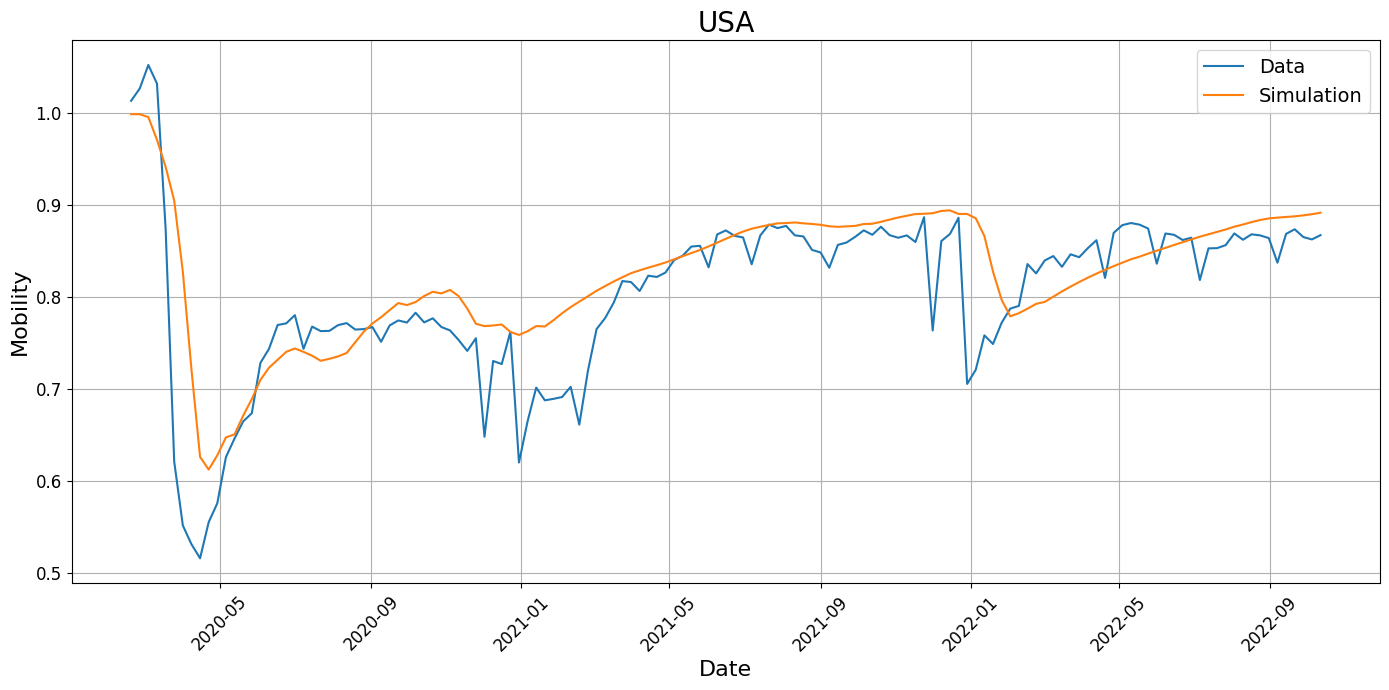

In [38]:
import matplotlib.pyplot as plt

# Calculate the Pearson correlation coefficient
r = all_states_mobility['adjusted_mobility'].corr(all_states_mobility_predicted)
# Calculate R² by squaring the correlation coefficient
R_squared = r**2

plt.figure(figsize=(14, 7))

# Plot the data
plt.plot(all_states_mobility.index,
         all_states_mobility['adjusted_mobility'],
         label='Data')
plt.plot(all_states_mobility_predicted.index,
         all_states_mobility_predicted,
         label='Simulation')

# Increase title and axis label font sizes
plt.title('USA', fontsize=20)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Mobility', fontsize=16)

# Rotate x-axis labels and increase their font size
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Increase legend font size
plt.legend(fontsize=14)
plt.grid(True)

# Automatically adjust layout so labels don’t get cut off
plt.tight_layout()

plt.show()


0


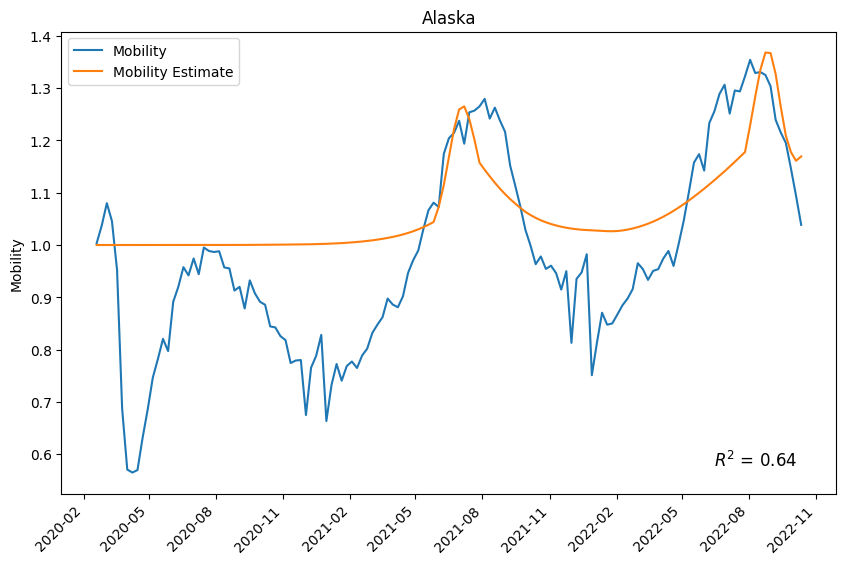

1


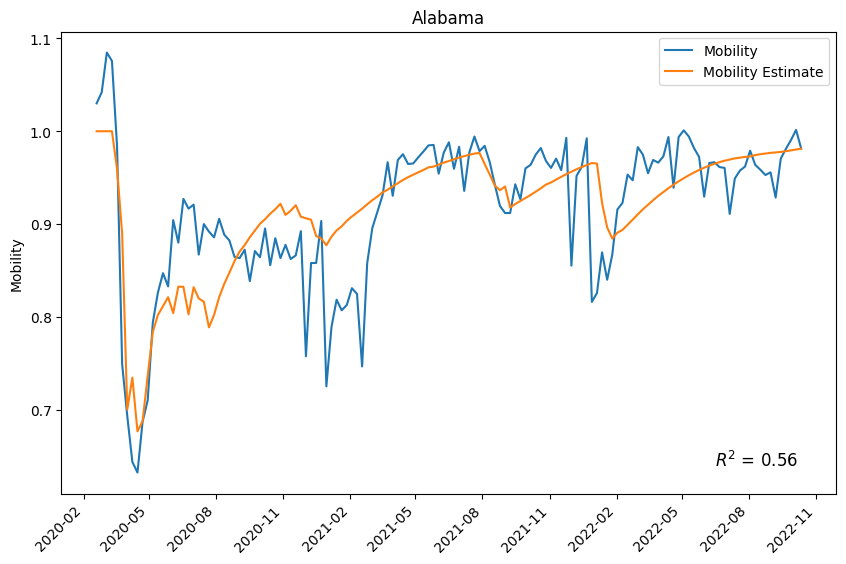

2


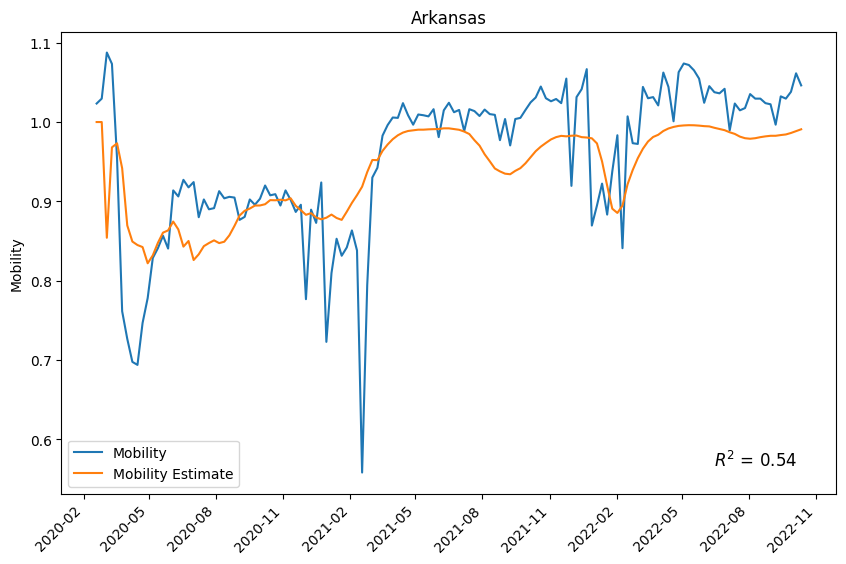

3


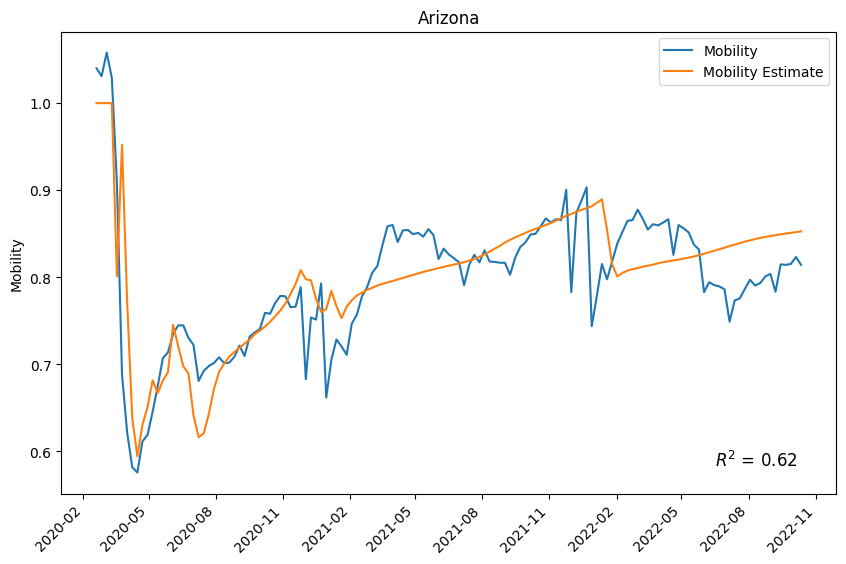

4


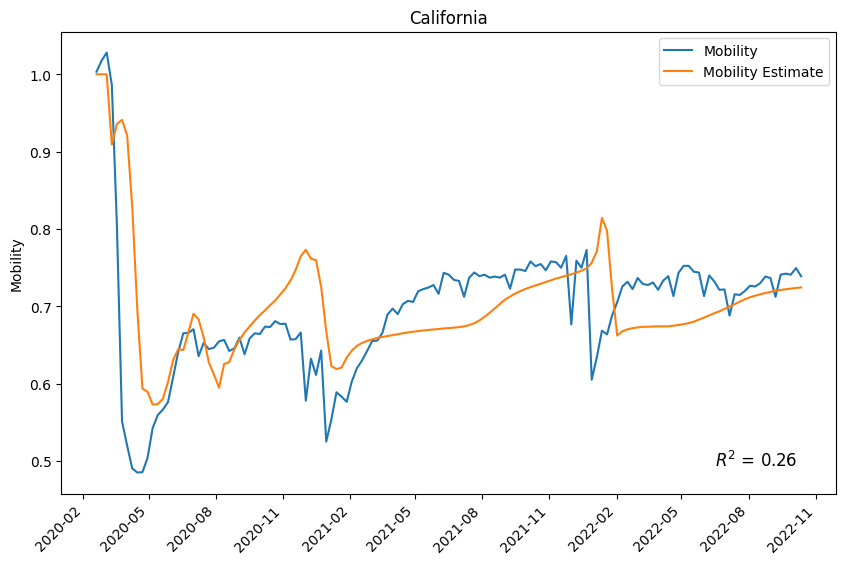

5


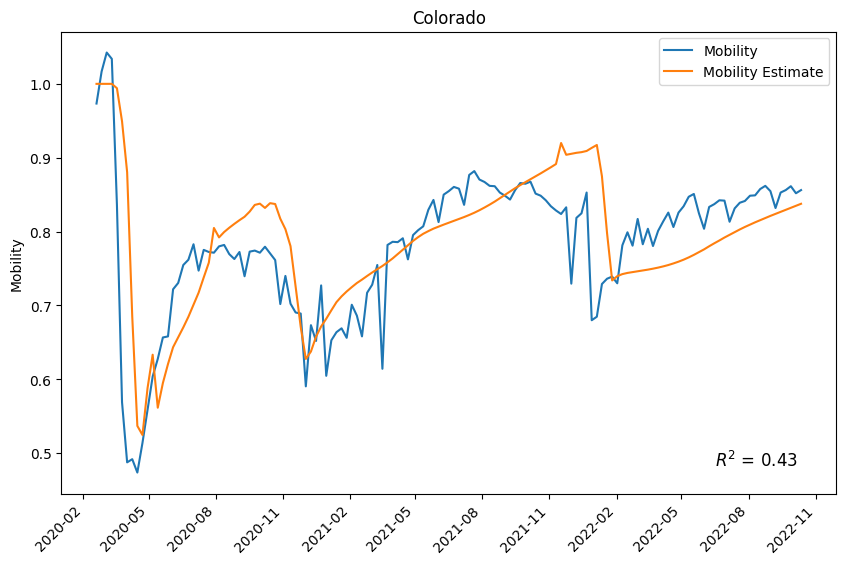

6


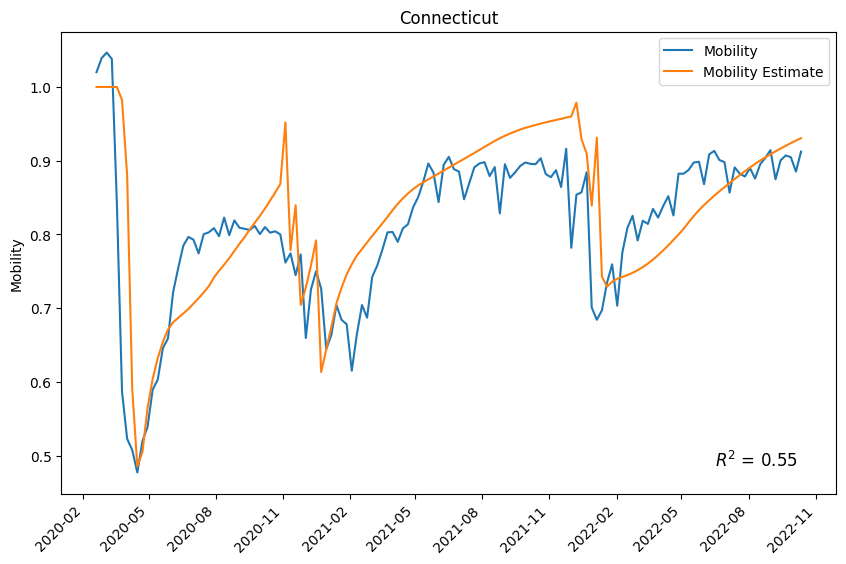

7


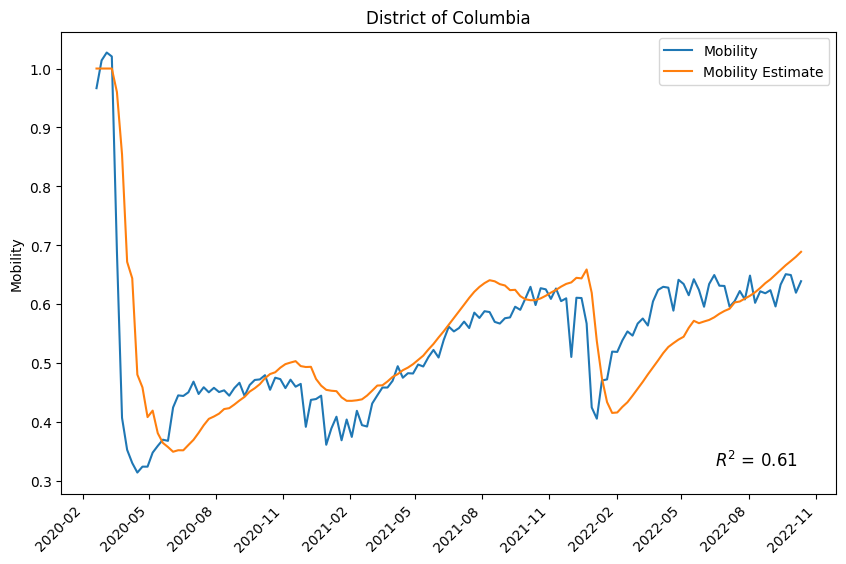

8


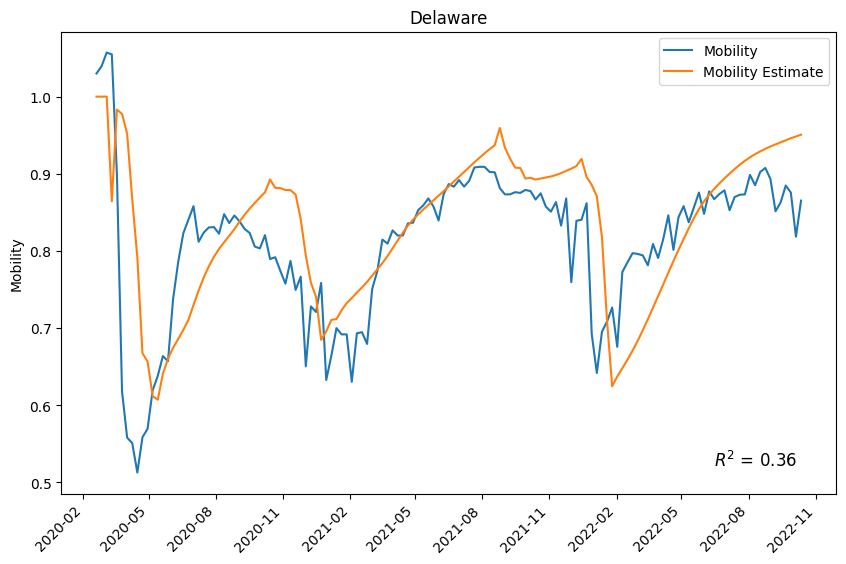

9


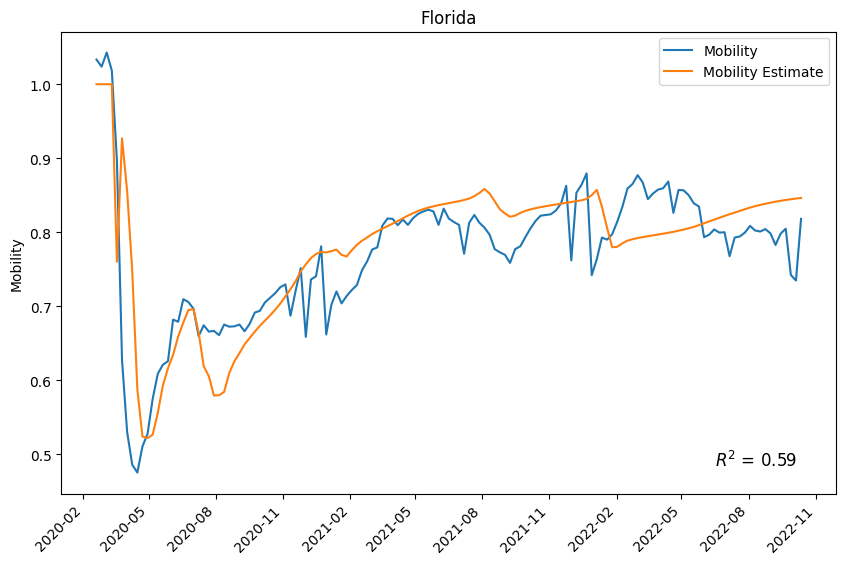

10


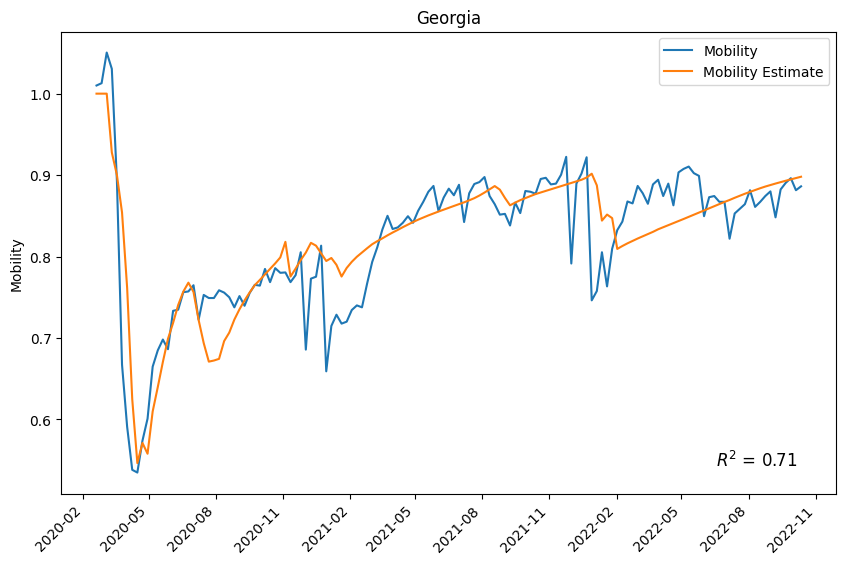

11


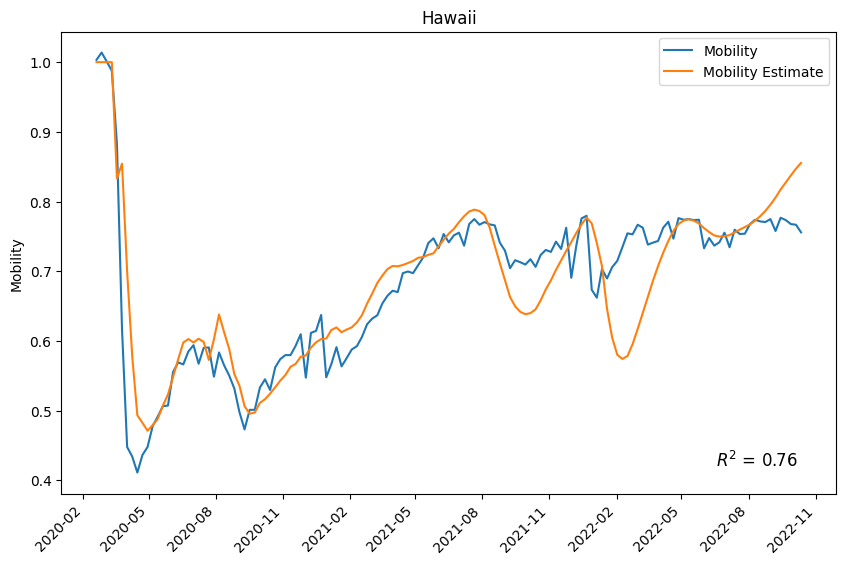

12


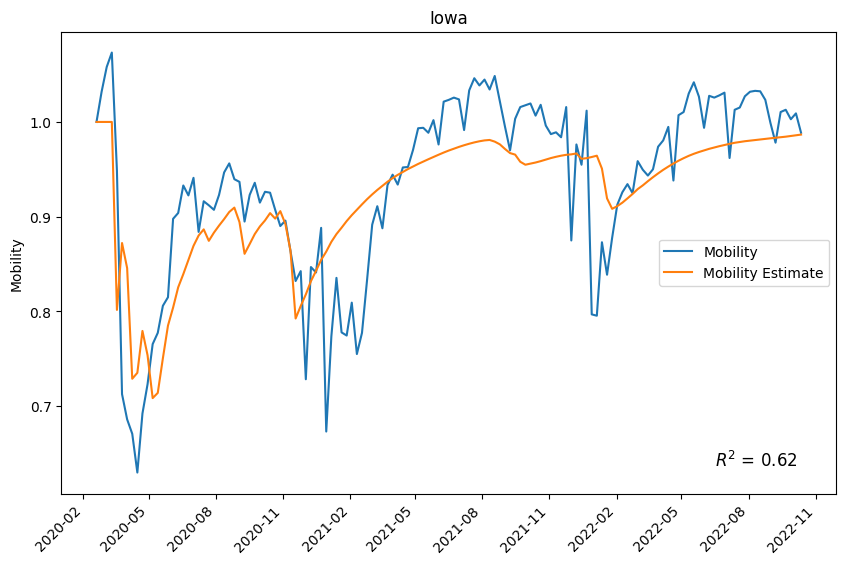

13


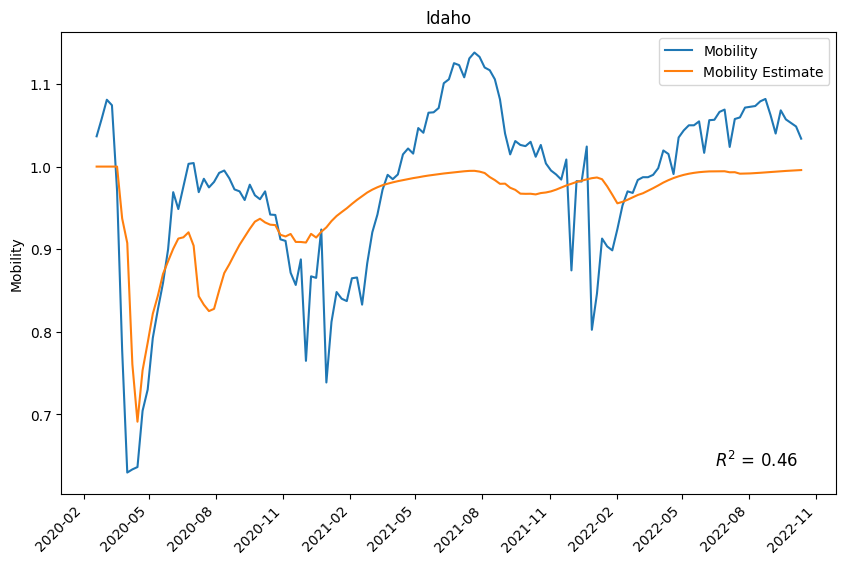

14


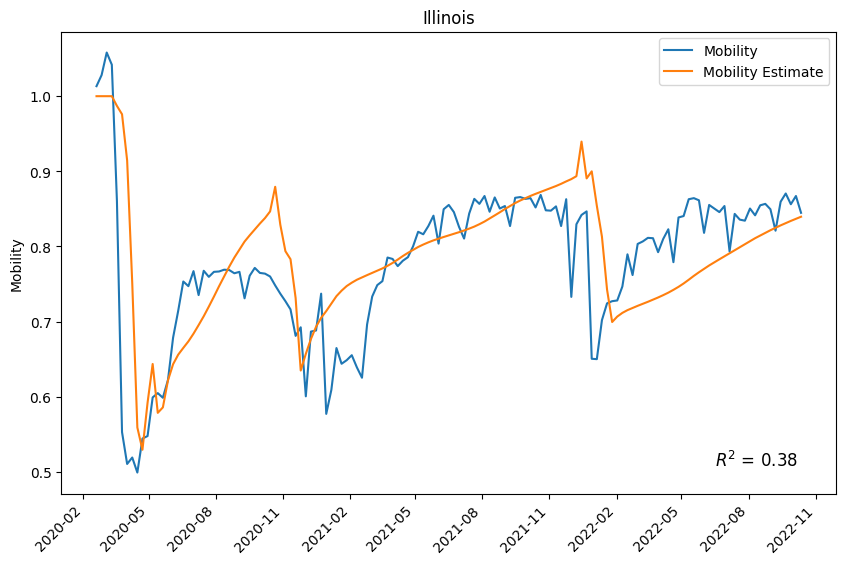

15


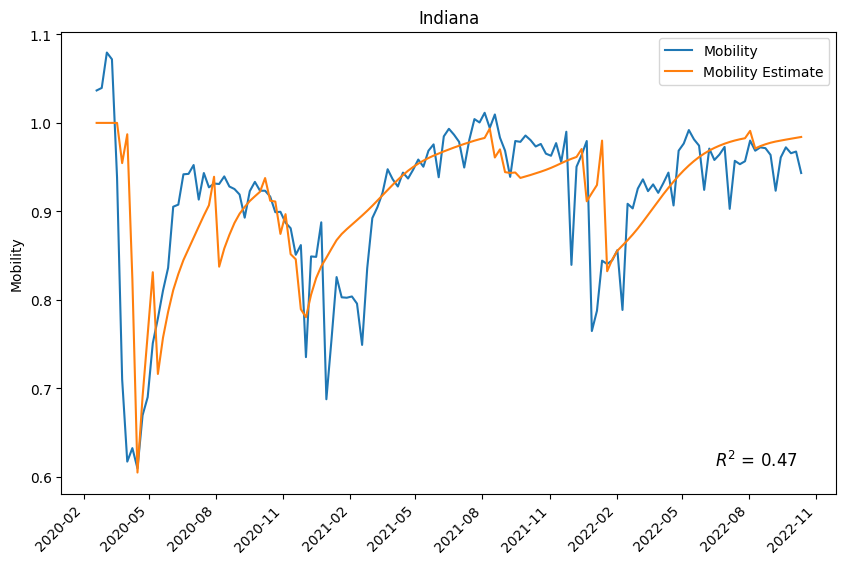

16


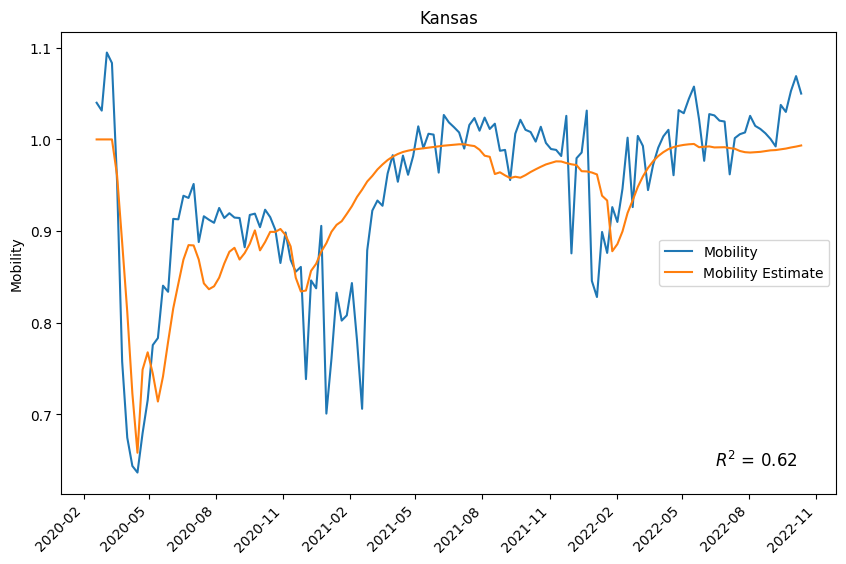

17


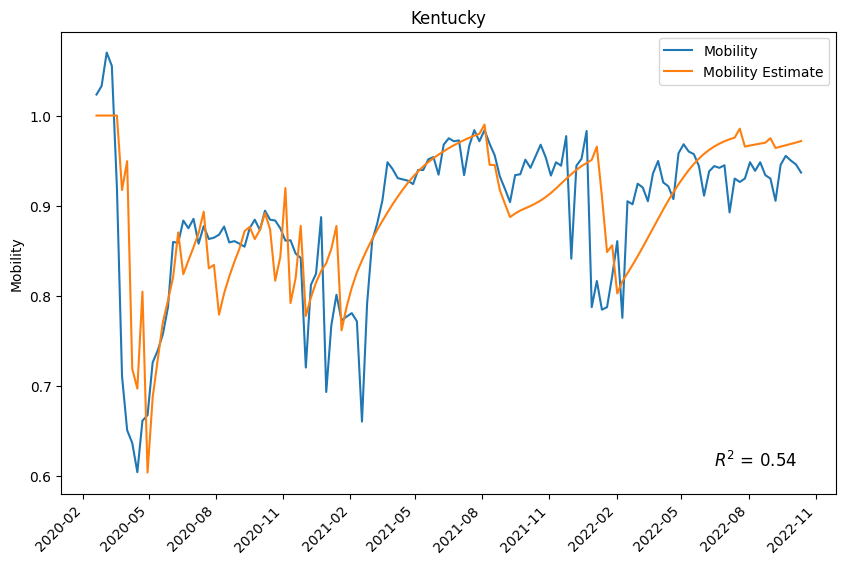

18


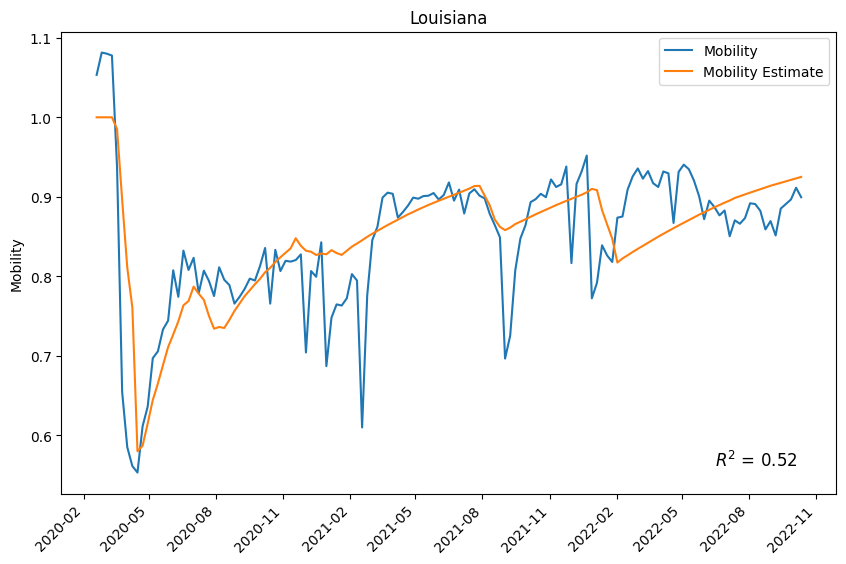

19


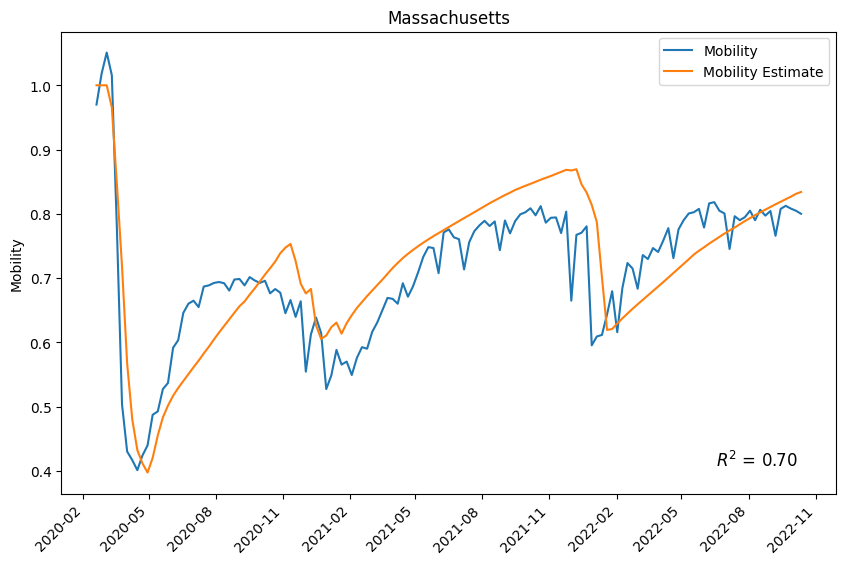

20


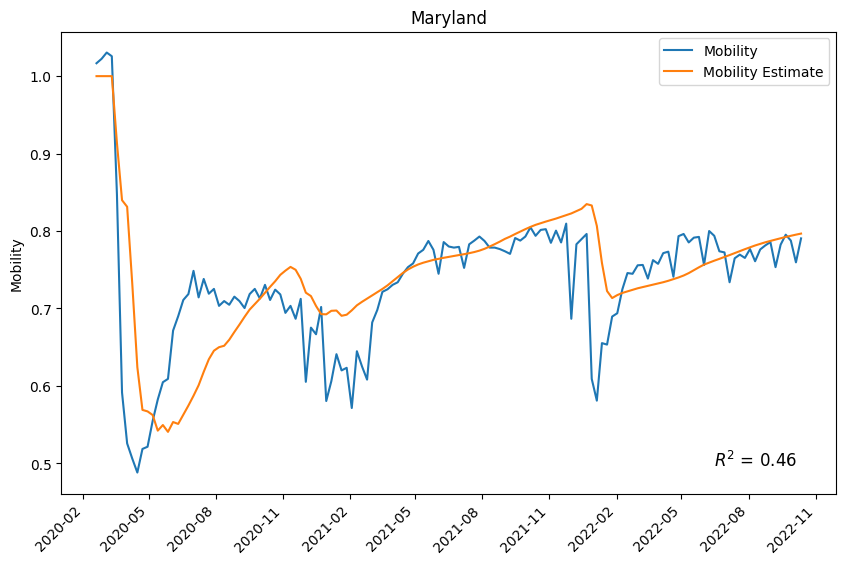

21


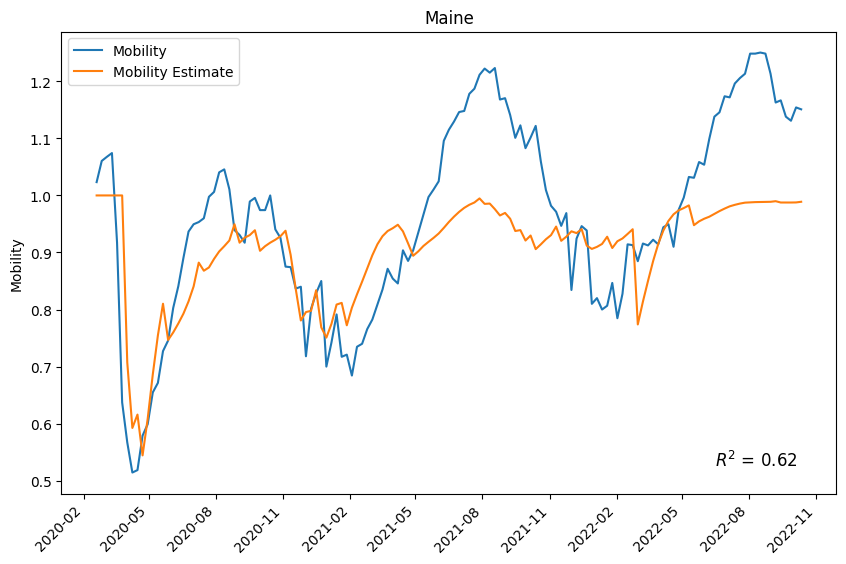

22


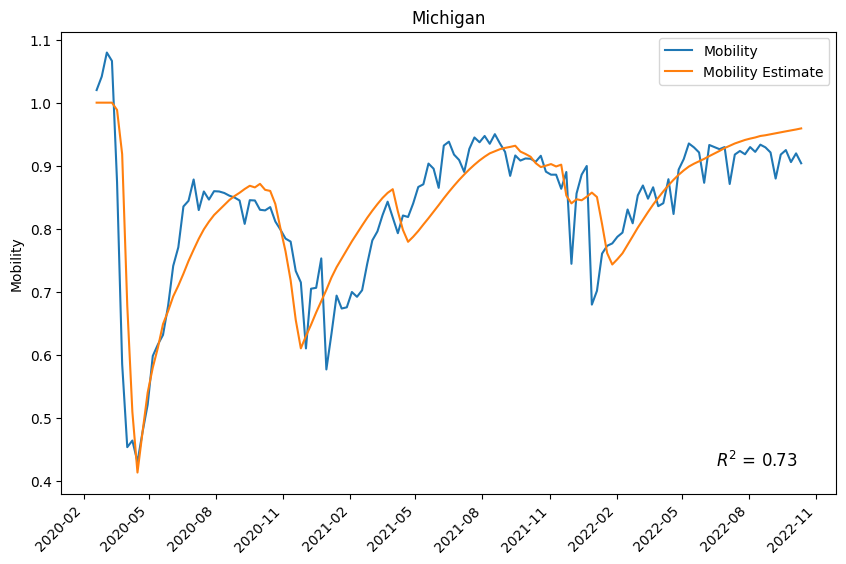

23


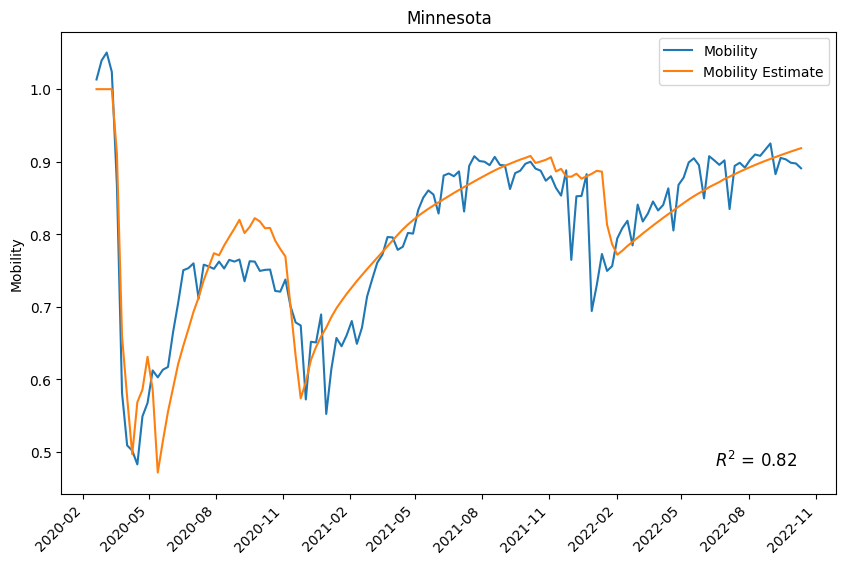

24


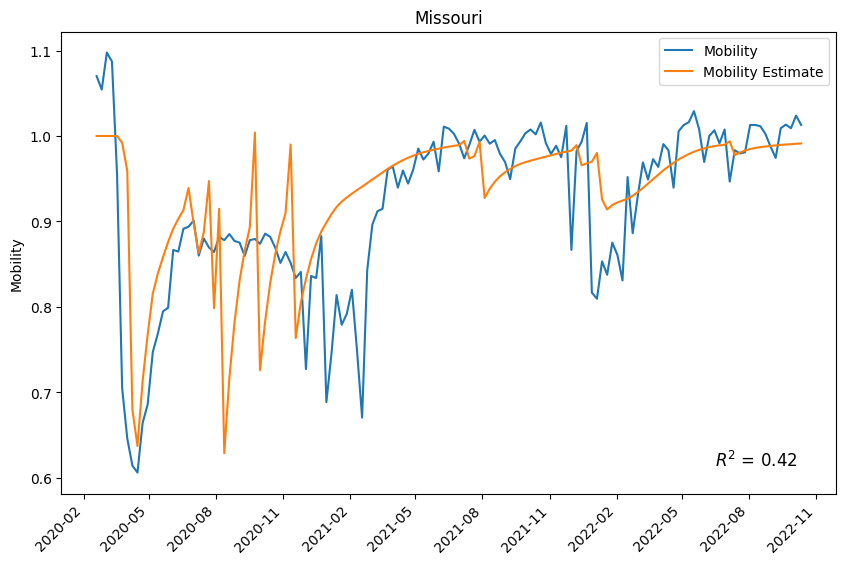

25


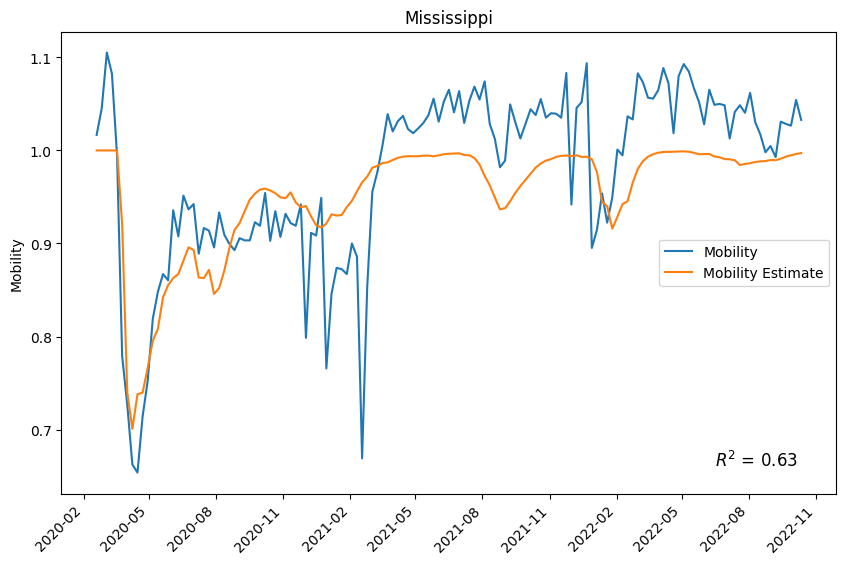

26


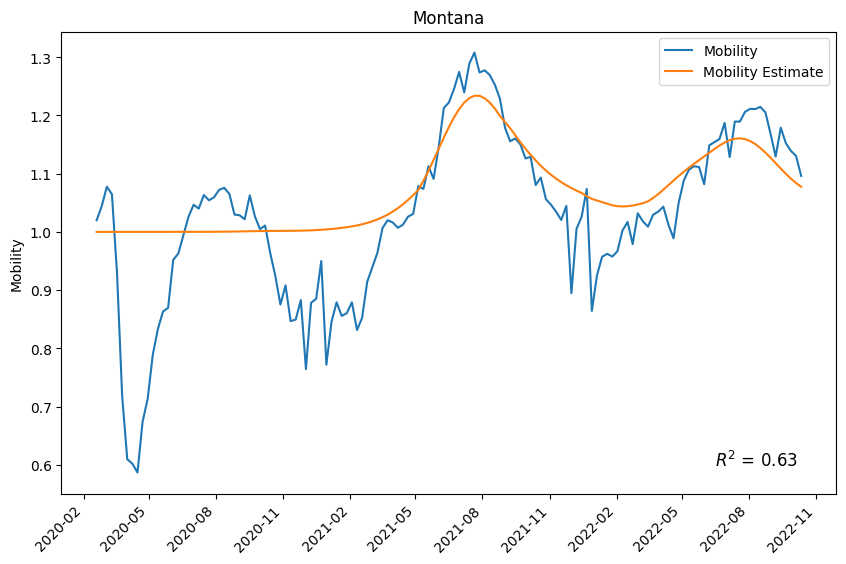

27


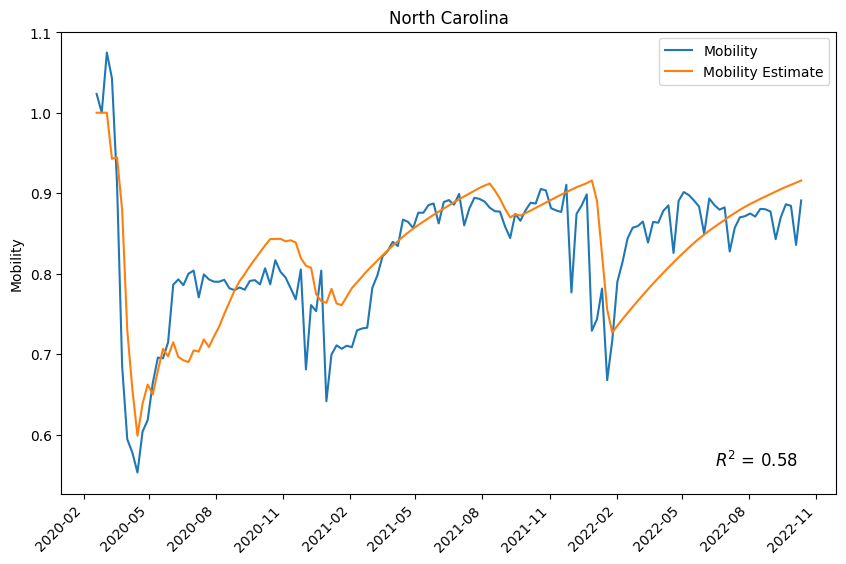

28


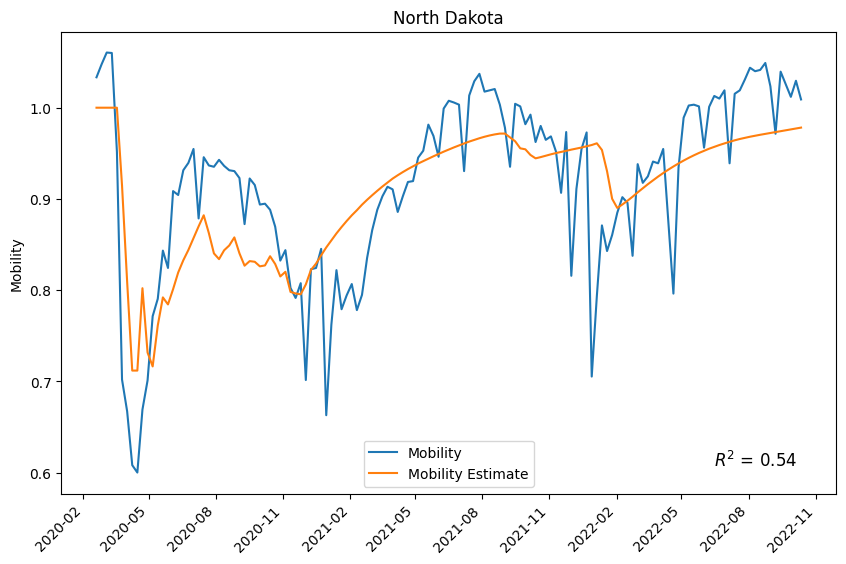

29


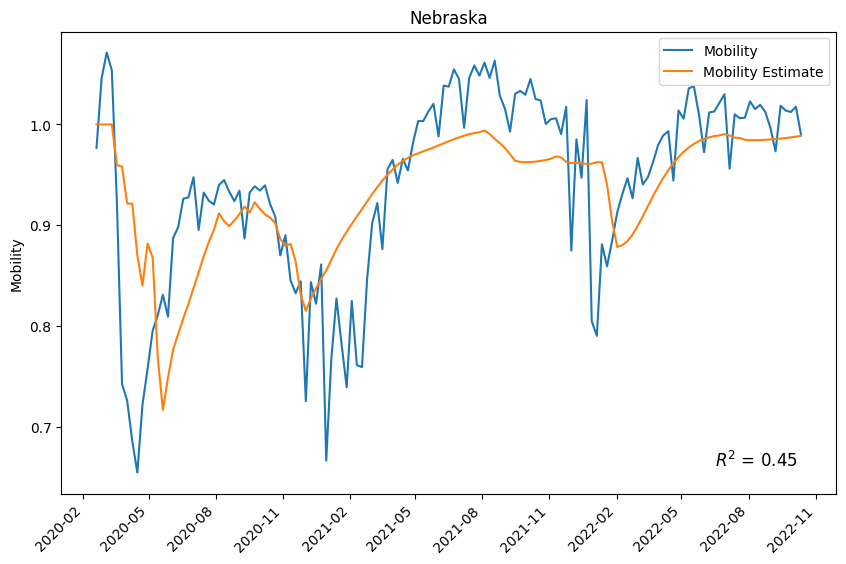

30


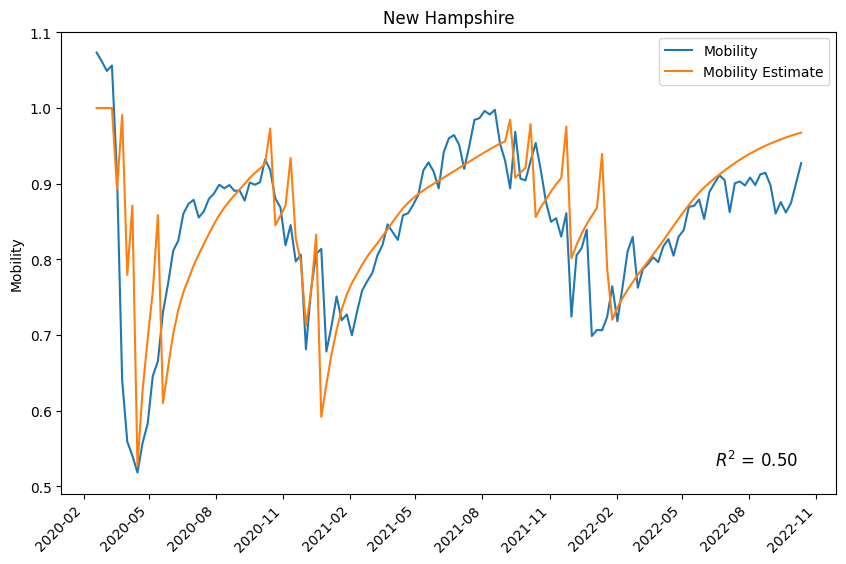

31


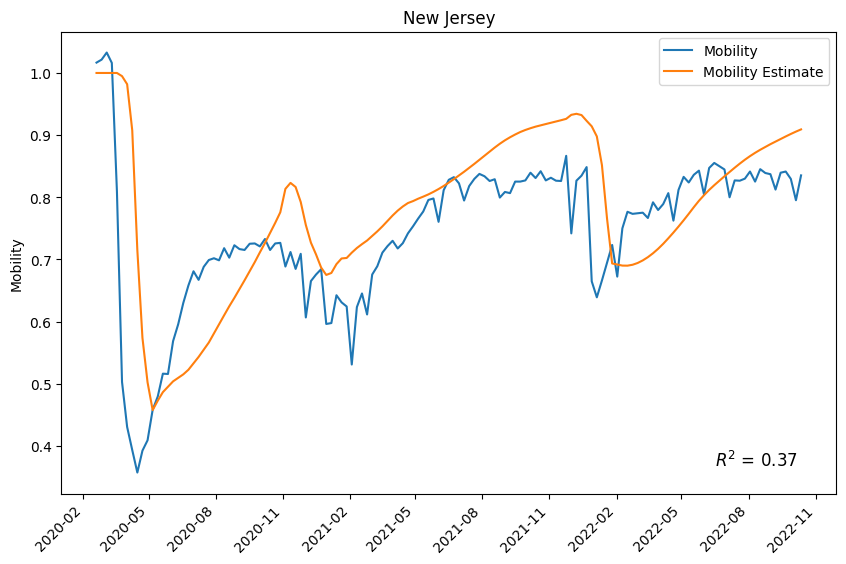

32


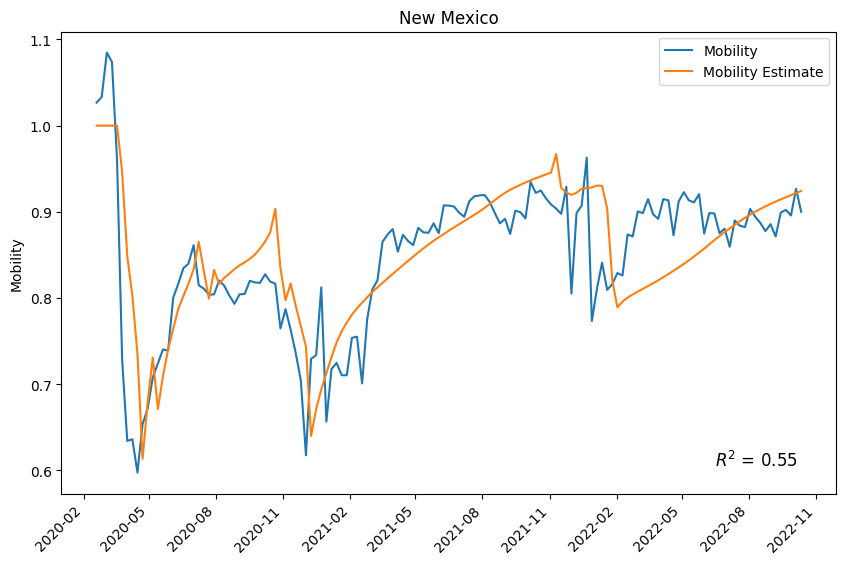

33


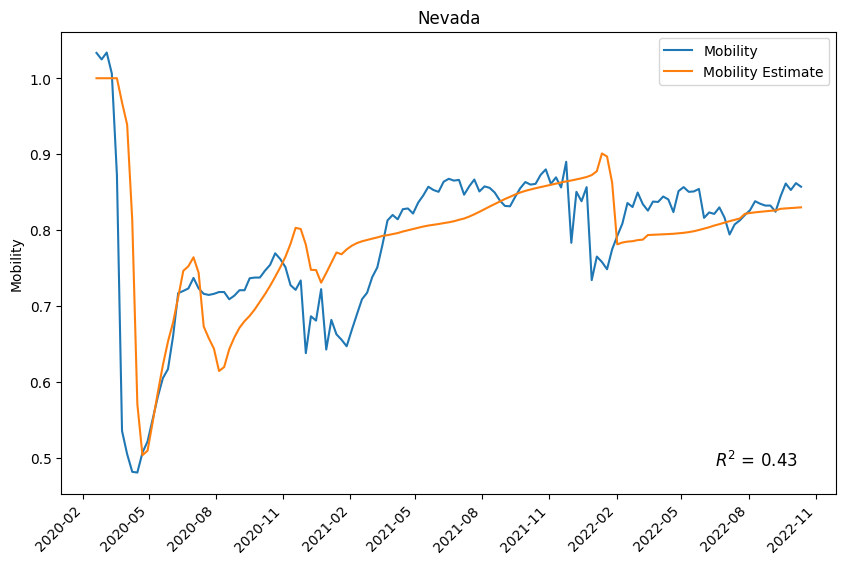

34


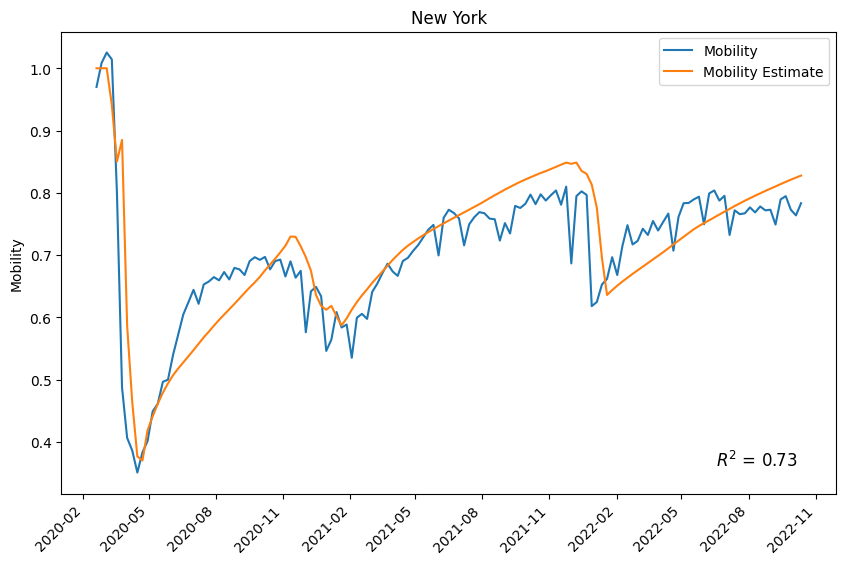

35


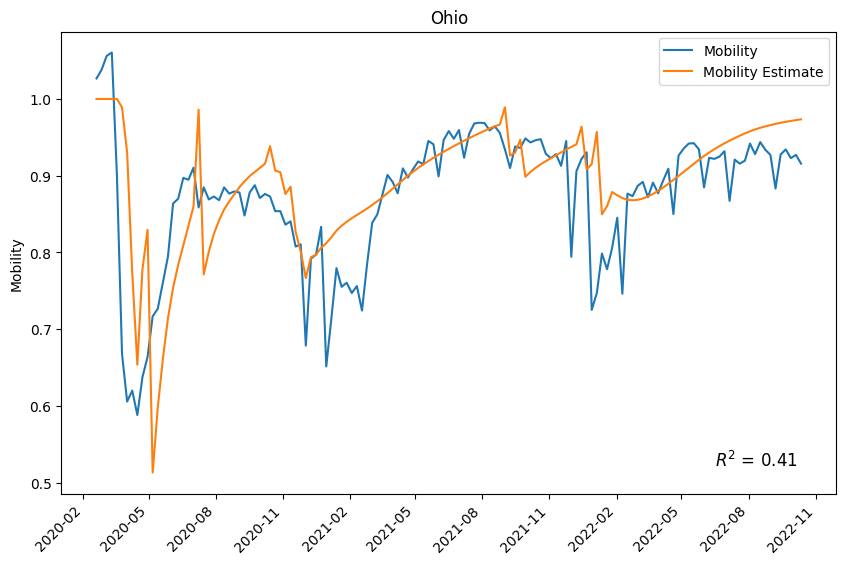

36


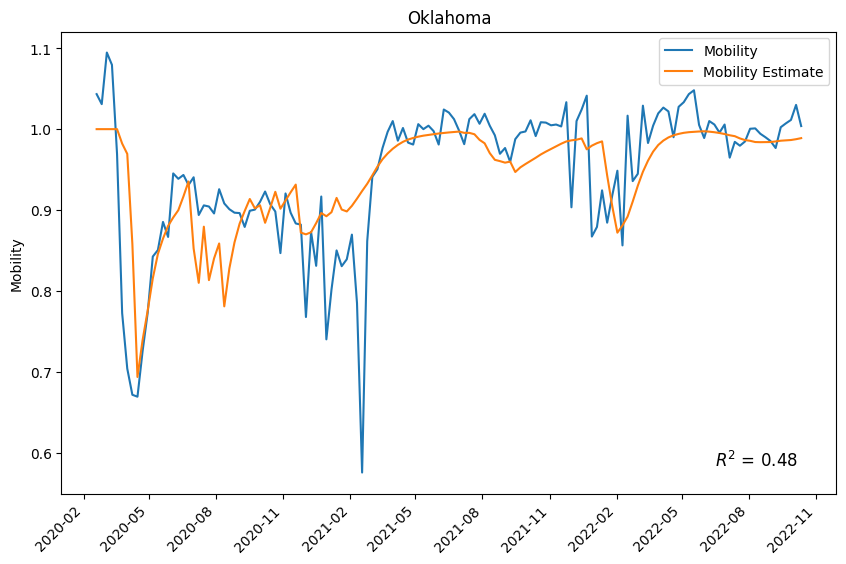

37


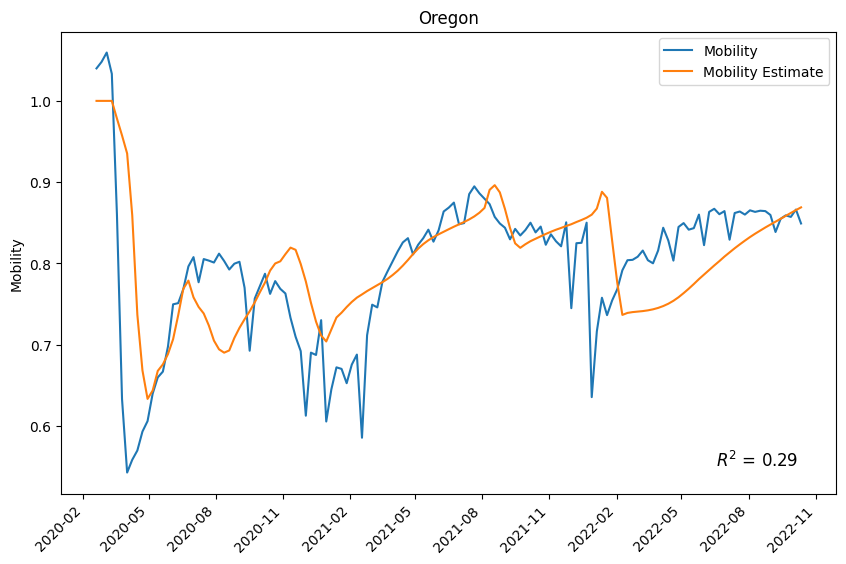

38


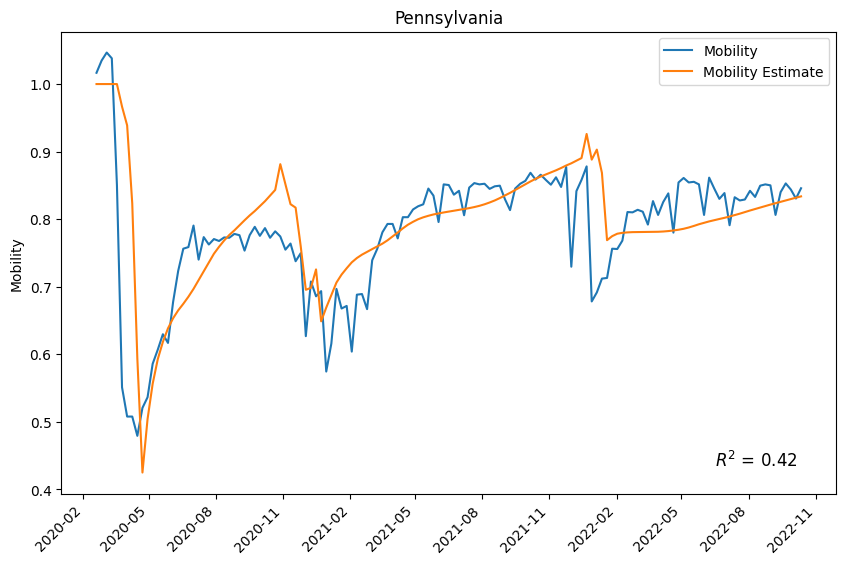

39


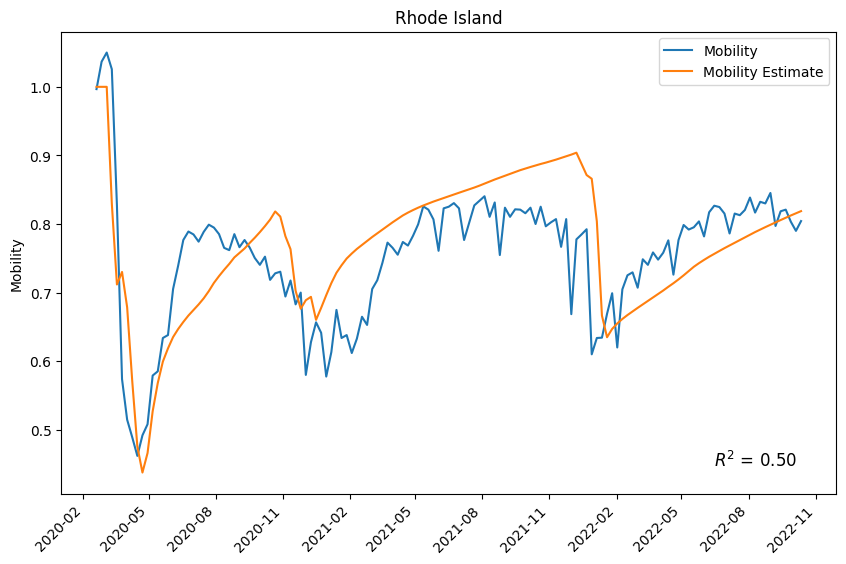

40


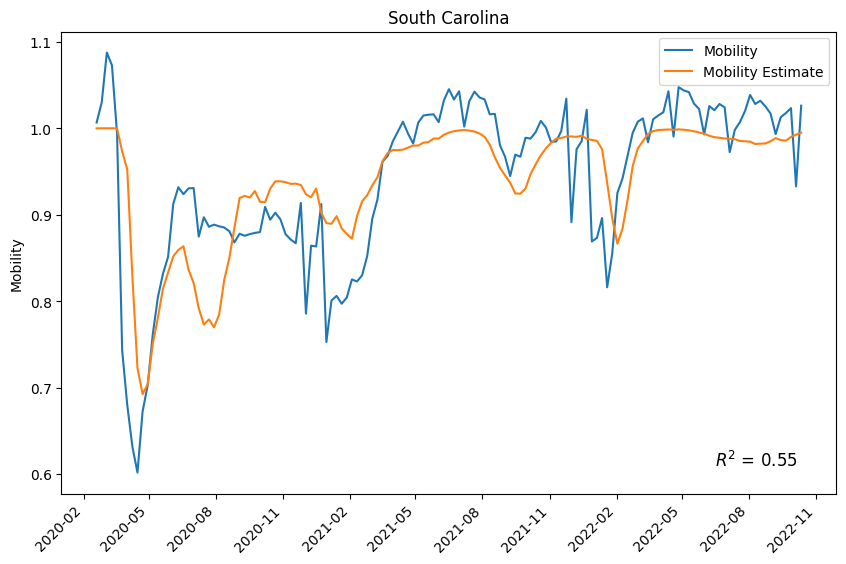

41


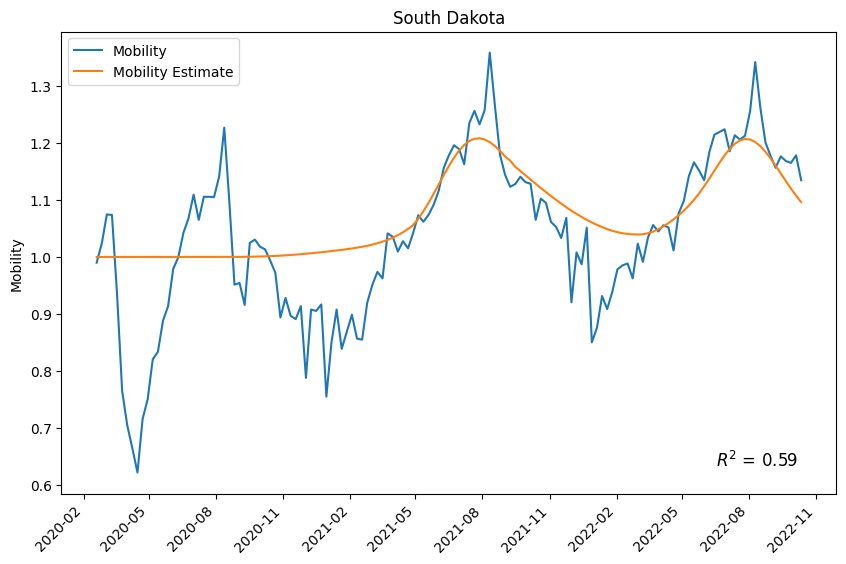

42


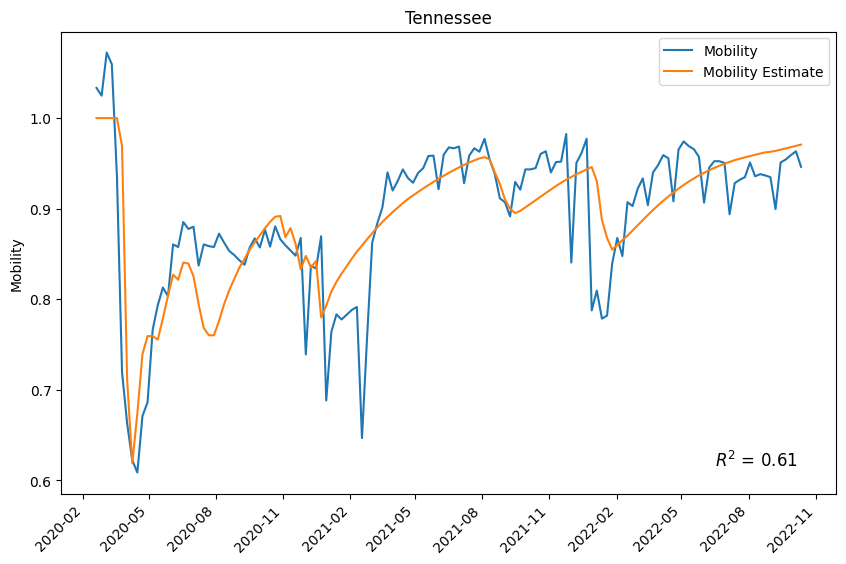

43


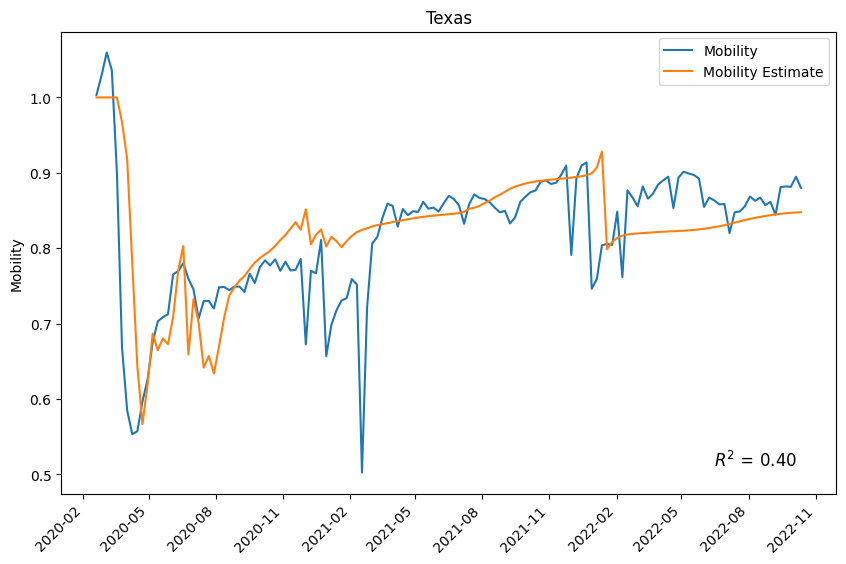

44


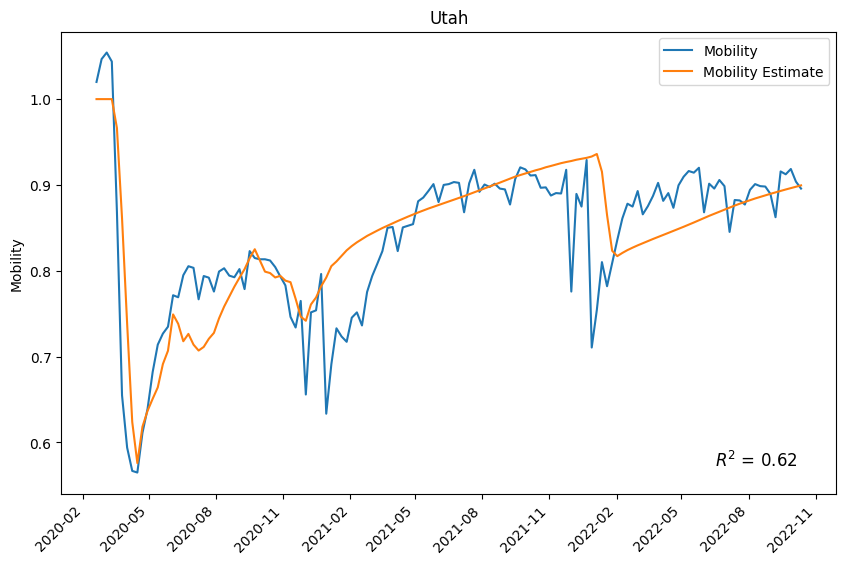

45


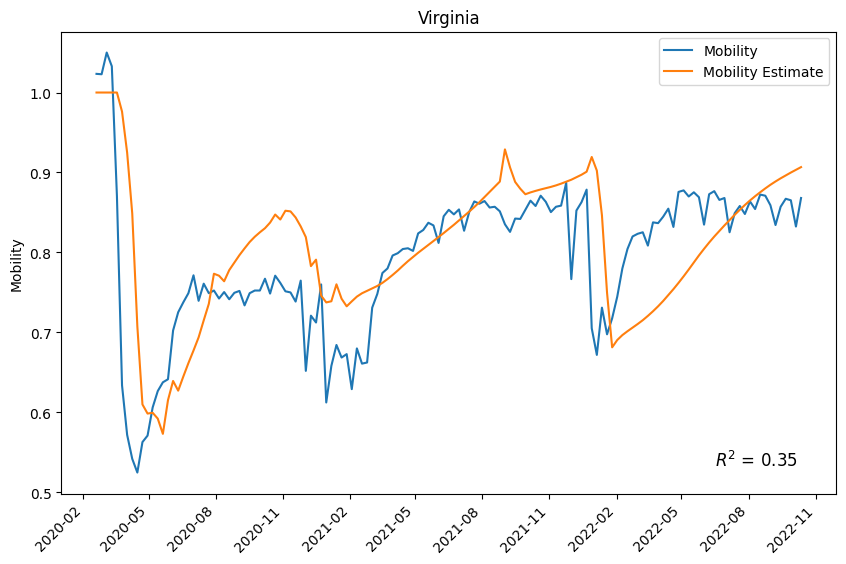

46


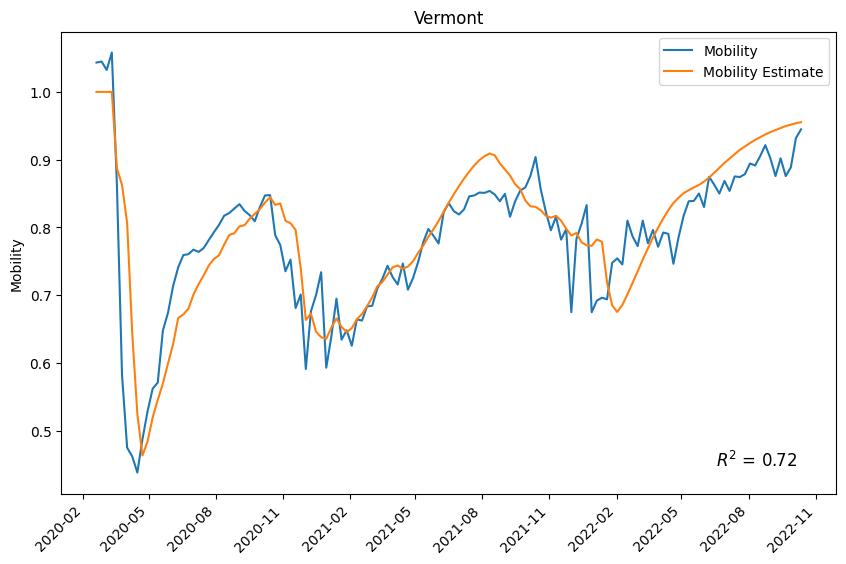

47


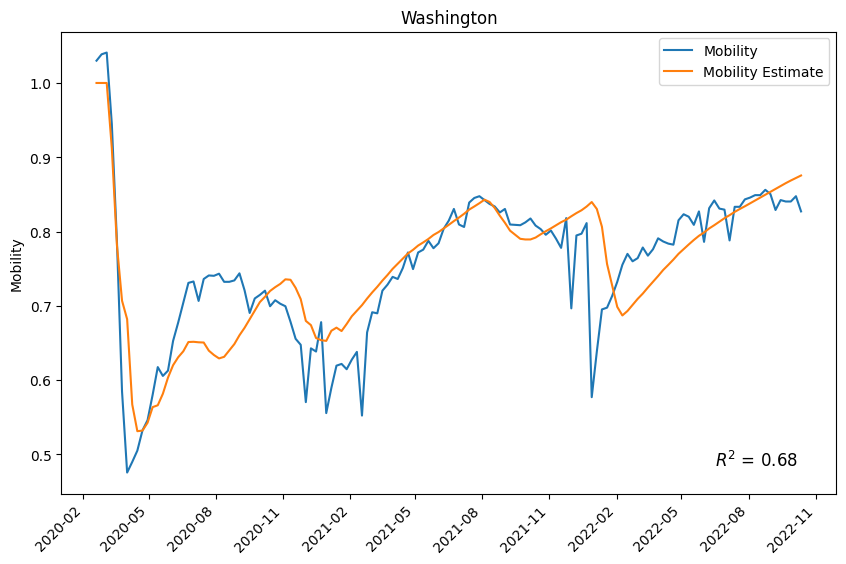

48


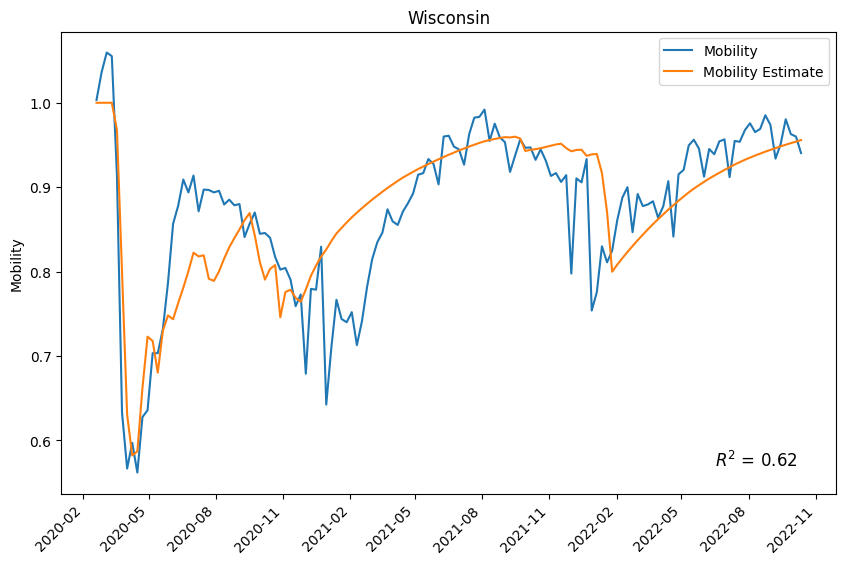

49


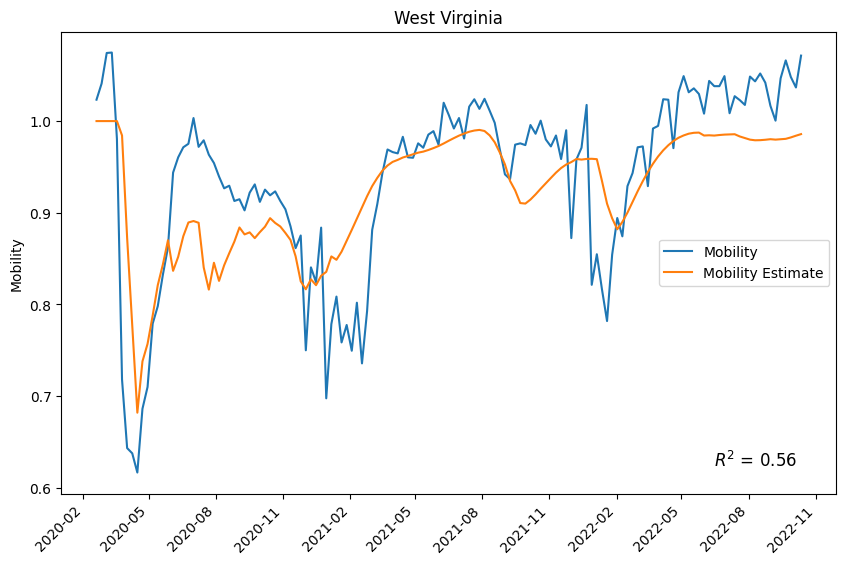

50


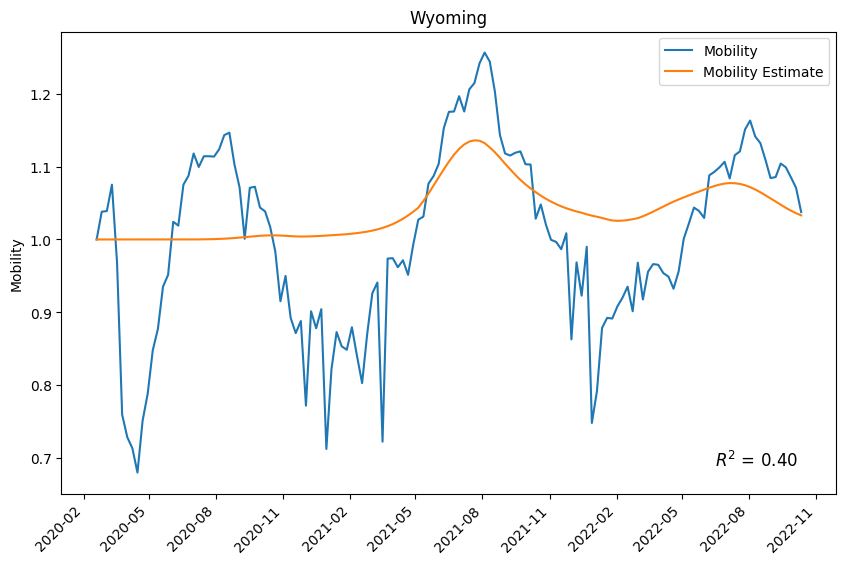

In [39]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


for s in range(51):
    
    values= state_dict[s]

    d1=answers_asy.loc[s, 'best_delay1']
    #d1= 1
    d2=answers_asy.loc[s, 'best_delay2']
    #d2= 5
    o= answers_asy.loc[s, 'best_order']
    #o= 1
    alpha = answers_asy.loc[s, 'best_alpha']


    df = values.copy()
    df = df.reset_index(drop=True)

    o = round(o)  # Ensure 'o' is an integer

    # Creating shifted columns based on the order 'o'
    for i in range(0, o + 1):
        column_name = f"B_est_{i}"
        df[column_name] = df["case_rate"].astype(float)

    # Applying the delay logic
    for i in range(0, len(df["case_rate"]) - 1):
        if df.loc[i, 'case_rate'] < df.loc[i, f'B_est_{o}']:
            d = d2
        else:
            d = d1

        for j in range(1, o + 1):
            prev_column = f'B_est_{j-1}'
            current_column = f'B_est_{j}'
            df.loc[i + 1, current_column] = df.loc[i, current_column] + (df.loc[i, prev_column] - df.loc[i, current_column]) / (d / o)

    # Preparing the X (independent variable) and y (dependent variable) arrays

    denominator = df['cumulative_case_rate'].copy()
    denominator[denominator == 0] = 1
    X = df[f"B_est_{o}"] / (denominator ** (alpha / 100))
    y = np.log(df['mobility']).values


    # Fitting the model using statsmodels
    model = sm.OLS(y, X).fit()

    # Getting the model's predictions
    y_pred = model.predict(X)

    # Calculating the Mean Squared Error manually, since statsmodels doesn't provide it directly
    mse = np.mean((y - y_pred) ** 2)

    # Extracting the model's coefficients
    # Note: In a model without an intercept, there's just one coefficient for the predictor
    coefficients = model.params
    # Mean Absolute Error
    #mae = mean_absolute_error(y, y_pred)
    # R-squared
    #r_squared = model.rsquared
    # AIC
    aic = model.aic
    # BIC
    #bic = model.bic
    # Confidence Intervals for the coefficients
    ci = model.conf_int()

    y= df['mobility'].values
    y_hat = np.exp(y_pred).values

    mae = np.mean(np.abs(y_hat - y))

    n = len(df['mobility']) #length of the data
    k = 1 #number of predictors
    bic = n * np.log((1/n) * np.sum((y - y_hat) ** 2)) + k * np.log(n)

    correlation_matrix = np.corrcoef(y_hat, y)
    correlation_coefficient = correlation_matrix[0, 1]



    r_squared = correlation_coefficient ** 2

    df = values.copy()
    df.reset_index(inplace=True)

    # Assuming state_dict[0] is already defined and 'date' is the DataFrame index

    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Adjust figure size for better readability
    plt.figure(figsize=(10, 6))

    # Plot with 'date' on the x-axis using df.index
    plt.plot(df.index, df['mobility'], label='Mobility')

    # Plot the predicted mobility
    plt.plot(df.index, np.exp(y_pred), label='Mobility Estimate')

    # Add legend, title, and labels
    plt.legend()
    print(s)
    state_name = state_dict[s]["state_full_name"].iloc[0]
    plt.title(f'{state_name}')
    plt.ylabel('Mobility')

    # Add R^2 value to the plot
    plt.text(0.95, 0.05, f'$R^2$ = {r_squared:.2f}',
            transform=plt.gca().transAxes,
            fontsize=12,
            verticalalignment='bottom',
            horizontalalignment='right')

    # Adjust the frequency and format of x-axis ticks
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Adjust interval as needed
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Adjust format as needed

    # Rotate and align date labels for better readability
    plt.xticks(rotation=45, ha='right')

    plt.show()


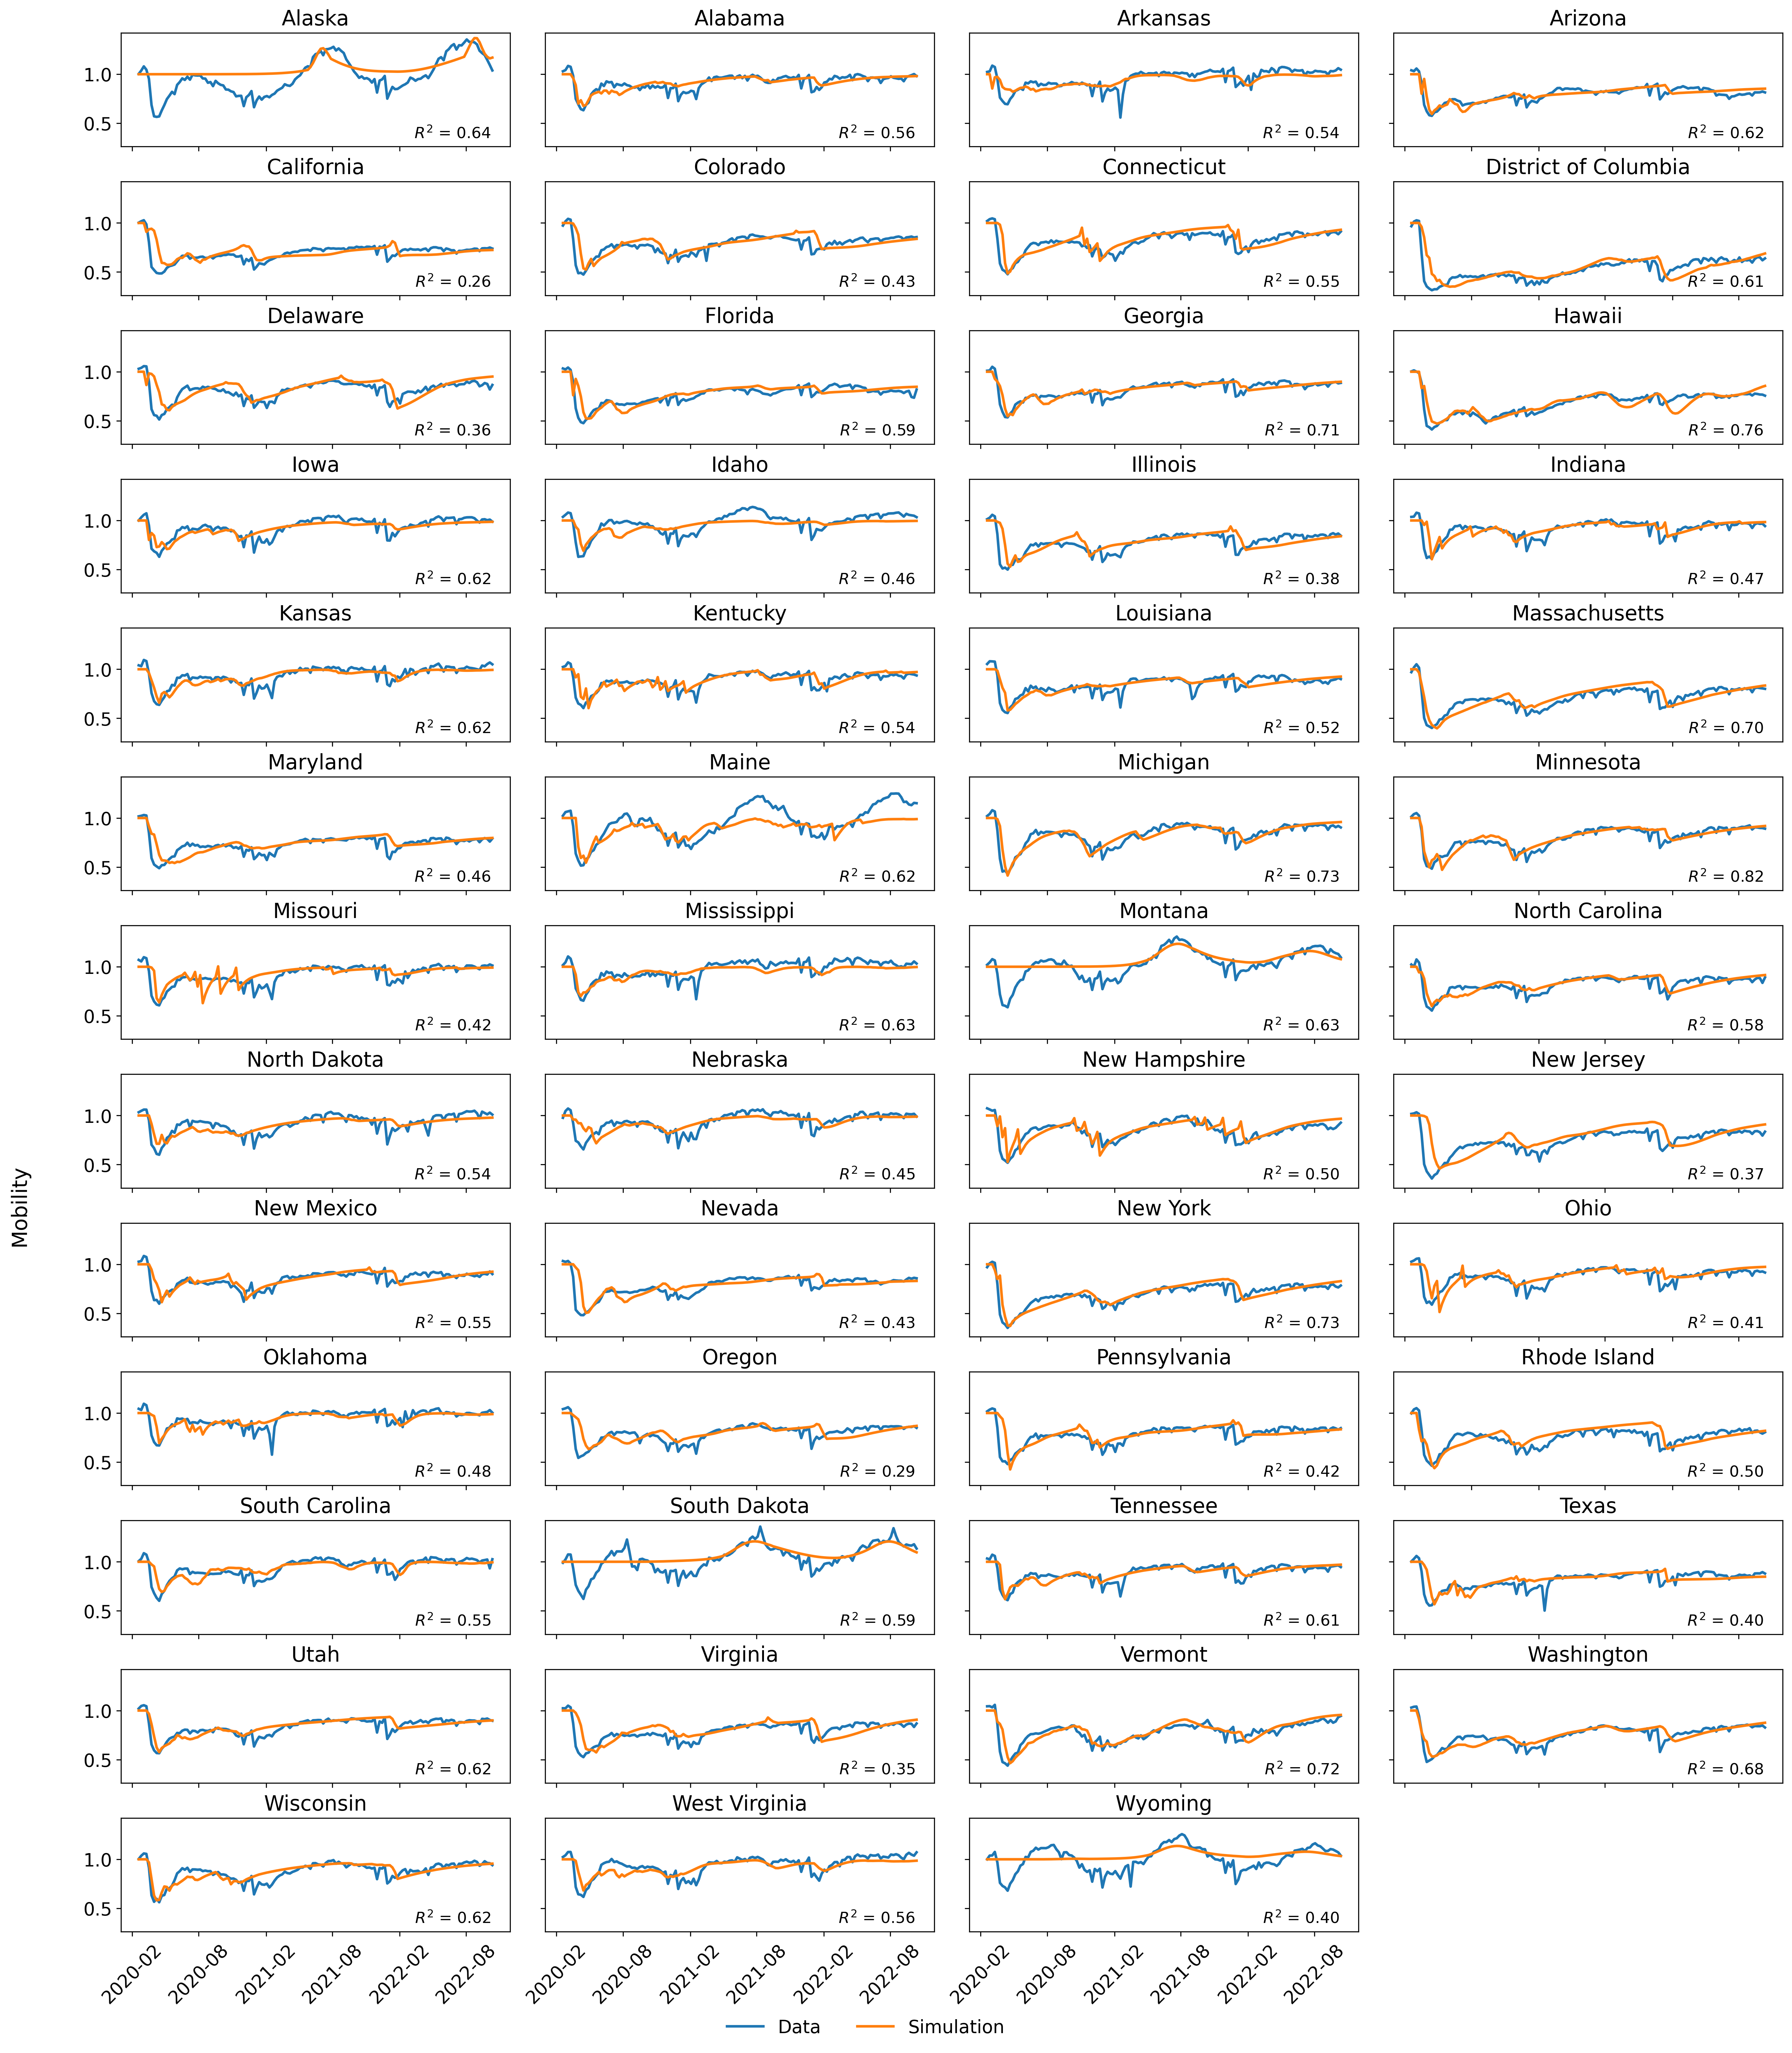

<Figure size 640x480 with 0 Axes>

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import statsmodels.api as sm
import math  # For ceiling function if needed

# Define the number of rows and columns for subplots
n_cols = 4
n_rows = 13  # Accommodating 51 plots (n_rows = ceil(51 / n_cols))

# Create a figure with higher DPI for better clarity in publications
fig, axes = plt.subplots(
    nrows=n_rows,
    ncols=n_cols,
    figsize=(20, 26),
    dpi=300,              # Higher DPI for improved clarity
    sharex=True,
    sharey=True
)
axes = axes.flatten()  # Flatten the array of axes for easy indexing

# Initialize lists to collect legend handles and labels
legend_handles = []
legend_labels = []

# Custom font sizes
title_fontsize = 16
label_fontsize = 16
tick_fontsize = 14
legend_fontsize = 14
r2_fontsize = 12

for s in range(51):
    ax = axes[s]  # Select the subplot to draw on
    
    values = state_dict[s]

    # Retrieve parameters for the current state
    d1 = answers_asy.loc[s, 'best_delay1']
    d2 = answers_asy.loc[s, 'best_delay2']
    o = answers_asy.loc[s, 'best_order']
    alpha = answers_asy.loc[s, 'best_alpha']

    df = values.copy()

    # Name the index as 'date' if it's not already named
    if df.index.name != 'date':
        df.index.name = 'date'
    df.reset_index(inplace=True)

    # Ensure 'date' is in datetime format
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    o = round(o)  # Ensure 'o' is an integer

    # Creating shifted columns based on the order 'o'
    for i in range(0, o + 1):
        column_name = f"B_est_{i}"
        df[column_name] = df["case_rate"].astype(float)

    # Applying the delay logic
    for i in range(0, len(df["case_rate"]) - 1):
        if df.iloc[i]['case_rate'] < df.iloc[i][f'B_est_{o}']:
            d = d2
        else:
            d = d1
        for j in range(1, o + 1):
            prev_column = f'B_est_{j-1}'
            current_column = f'B_est_{j}'
            df.iloc[i + 1, df.columns.get_loc(current_column)] = (
                df.iloc[i][current_column] +
                (df.iloc[i][prev_column] - df.iloc[i][current_column]) / (d / o)
            )

    # Preparing the X and y arrays
    denominator = df['cumulative_case_rate'].copy()
    denominator[denominator == 0] = 1
    X = df[f"B_est_{o}"] / (denominator ** (alpha / 100))
    y = np.log(df['mobility']).values

    # Fitting the model using statsmodels
    model = sm.OLS(y, X).fit()
    y_pred = model.predict(X)

    # Calculating R-squared
    y_actual = df['mobility'].values
    y_hat = np.exp(y_pred).values
    correlation_matrix = np.corrcoef(y_hat, y_actual)
    correlation_coefficient = correlation_matrix[0, 1]
    r_squared = correlation_coefficient ** 2

    # Plot the actual and predicted mobility
    line1, = ax.plot(df.index, df['mobility'], label='Mobility', linewidth=2)
    line2, = ax.plot(df.index, y_hat, label='Predicted Mobility', linewidth=2)

    # Collect legend handles and labels (only once, from the first subplot)
    if s == 0:
        legend_handles.extend([line1, line2])
        legend_labels.extend(['Data', 'Simulation'])

    # Set the title to the state's name
    state_name = values["state_full_name"].iloc[0]
    ax.set_title(f'{state_name}', fontsize=title_fontsize)

    # Add R^2 value to the subplot
    ax.text(
        0.95,
        0.05,
        f'$R^2$ = {r_squared:.2f}',
        transform=ax.transAxes,
        fontsize=r2_fontsize,
        verticalalignment='bottom',
        horizontalalignment='right',
    )

    # Adjust x-axis ticks and labels
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax.tick_params(axis='x', labelrotation=45, labelsize=tick_fontsize)
    ax.tick_params(axis='y', labelsize=tick_fontsize)

# Hide any unused subplots
for s in range(51, len(axes)):
    fig.delaxes(axes[s])

# Create a single legend for the entire figure
fig.legend(
    handles=legend_handles,
    labels=legend_labels,
    loc='lower center',
    bbox_to_anchor=(0.5, 0.15),  # Adjust y-value to bring legend higher if needed
    frameon=False,
    ncol=2,  # Use 2 columns as there are 2 legend entries
    fontsize=legend_fontsize
)

# Add a common y-axis label
fig.text(
    0.04, 0.5, 'Mobility',
    va='center',
    rotation='vertical',
    fontsize=label_fontsize
)

# Tight layout to reduce overlap; adjust bottom and left margins to allow room for the legend
plt.tight_layout()
plt.subplots_adjust(bottom=0.2, left=0.10)

# Optional: add a figure title
# fig.suptitle("Mobility vs. Predicted Mobility across States", fontsize=16)

plt.show()

# Optional: save the figure to a file with high DPI for publication.
plt.savefig("mobility_plots.png", dpi=300, bbox_inches='tight')
